# Préambule

## Introduction & Contexte

Ce projet a été réalisé par 3 étudiants de Master 1 à l'ENSAE, dans le cadre du cours "Python for Data Science".
L'idée de ce projet vient d'une intuition que nous avons eu, selon laquelle il pourrait être possible de prédire le succès d'un jeu vidéo auprès des utilisateurs à partir de certaines de ses caractéristiques. L'objectif principal de ce travail est donc de tenter de vérifier ou infirmer cette intuition à l'aide de techniques statistiques de traitement de données. 

En réfléchissant de façon naïve à la question suivante : " Quelles sont les caractéristiques d'un jeu vidéo qui vont le plus impacter son succès auprès des utilisateurs ? ", on peut apporter quelques pistes de réponses: il semble raisonnable de supposer que 6 grandes catégories de caractéristiques d'un jeu vont avoir une influence sur le succès du jeu : 

1-le nombre d'utilisateurs d'un jeu \
2-l'engouement autour du jeu \
3-le scénario et synopsis du jeu \
4-le type d'expérience de jeu, ie le genre du jeu (jeu de tir, de combat, de stratégie, etc) \
5-la qualité des graphismes et du gameplay, de l'expérience de jeu \
6-le budget du jeu 



Nous allons donc vérifier si en effet, ces caractéristiques impactent le succès des jeux auprès des utilisateurs. Le succès d'un jeu sera ici représenté par l'aggrégation des notes données par les utilisateurs et par les rédacteurs du site Metacritic (il s'agit d'une plateforme de review de jeux vidéos). Les 6 catégories de caractéristiques que nous avons identifié ne sont pas des données quantifiables où auxquelles nous avons accès, donc nous allons essayer de les reproduire au moyen de caractéristiques quantifiables et accessibles sur internet. 


# Importation des modules 

## Modules de webscrapping

On installe les packages utiles au Webscrapping des données sur les jeux.

In [1]:
# On importe les packages
!pip install unicode
!pip install unidecode
!pip install requests_html
!pip install igdb-api-v4
!pip install requests

import requests 
import urllib
import bs4
from requests_html import HTMLSession
from tqdm import tqdm
from unidecode import unidecode
import datetime
import time

from igdb.wrapper import IGDBWrapper
from igdb.igdbapi_pb2 import GenreResult
from igdb.igdbapi_pb2 import ThemeResult
from igdb.igdbapi_pb2 import GameResult
from igdb.igdbapi_pb2 import InvolvedCompanyResult
from igdb.igdbapi_pb2 import PlayerPerspectiveResult
from igdb.igdbapi_pb2 import MultiplayerModeResult
from igdb.igdbapi_pb2 import ArtworkResult
from igdb.igdbapi_pb2 import AgeRatingResult
from igdb.igdbapi_pb2 import CompanyResult
from igdb.igdbapi_pb2 import CollectionResult
from igdb.igdbapi_pb2 import GameEngineResult
from igdb.igdbapi_pb2 import FranchiseResult


#Cela va run le notebook functions_scrapping et nous allons pouvoir utiliser les fonctions dans ce notebook
#%run -i functions_scrapping.ipynb

In [2]:
wrapper = IGDBWrapper("wlqlv1d19z5t69oqlf9xx69znfahze", "o2strnp2xj90l3p982n4jg9ko1utad")

## Importation des modules de Visualisation & Modélisation des données

In [3]:
#Là on importe les autres packages
#!pip install pandas_profiling 
#!pip install pydantic-settings
!pip install plotly
!pip install fancyimpute

from collections import Counter
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from fancyimpute import KNN
from sklearn.cluster import KMeans

#from pandas_profiling import ProfileReport
#from pydantic_settings import BaseSettings

# I/ Récupération des données

## I/A Webscrapping des titres des jeux vidéos sur Wikipédia

A partir du site Wikipédia, nous allons récupérer les titres de tous les jeux vidéos sortis depuis l'année 2000. Par exemple, depuis l'URL : https://en.wikipedia.org/wiki/Category:2023_video_games nous avons accès à la liste de la quasi-totalité des jeux vidéos sortis en 2023. Nous allons donc modifier l'URL pour chaque année et constituer une liste (Liste_VG)

Notre objectif sera ensuite de croiser les données extraites sur wikipédia avec celles de Metacritic, un site de reviews de jeux vidéos

In [4]:
#Url initial : https://en.wikipedia.org/wiki/2023_in_video_games
Liste_VG = []

d = {15 : 10, 16 : 9, 17: 11, 18 : 9, 19 : 9, 20: 12, 21: 11, 22 : 7}
for i in range(15, 23) :
    
    
    response = requests.get(url="https://en.wikipedia.org/wiki/20"+str(i)+"_in_video_games")
    soup = bs4.BeautifulSoup(response.content, 'html.parser')
    tableau_participants = soup.findAll('table', {'class' : 'wikitable'})
    for j in range(d[i], d[i]+4) :
        rows = tableau_participants[j].find_all('tr')
        first = True
        for row in rows :
            if first :
                first = False
            else:
                title = row.find('i')
                if title != None :
                    Liste_VG.append((row.find('i').text))
                
                    
#print(Liste_VG)

## I/B Récupération des notes des jeux

L'objectif de cette partie est d'extraire du site "Métacritic", un site spécialisé qui répertorie les avis de professionnels et d'utilisateurs sur les nouvelles sorties jeux vidéos. Pour chaque jeu dans la base de données du site, une note sur 100 est attribuée (moyenne des reviews de sites spécialisés jeux vidéos) et une note sur 10 attribuée par les utilisateurs du site. Nous allons ici récupérer pour chaque jeu ses notes Métacritic qui deviendront les variables que nous tenteront de prédire par la suite. 

On remarque que l'on peut atteindre la review du jeu à partir de l'URL, il suffit d'indiquer le titre du jeu dans l'URL, en faisant attention aux espaces. 

Ici, nous allons remarquer que l'accès à Métacritic est interdit via la bibliothèque Beautifoul Soup

In [5]:
#URL du site : https://www.metacritic.com/game/
#URL d'une recherche : https://www.metacritic.com/search/gran%20theft%20auto/
#URL d'une review : https://www.metacritic.com/game/grand-theft-auto-v/
#URL d'une review d'un autre site spécialisé : https://www.ign.com/games/grand-theft-auto-v

#Base URL de toutes les reviews
URL = "https://www.metacritic.com/game/"

#user_agent = {'User-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/62.0.3202.94 Safari/537.36'}
#site = requests.get(URLbis, user_agent)
#print(site.status_code)

In [6]:
def title_to_slug(title):
    
    title = title.lower()
    title = title.replace(':', '')
    title = title.replace('•', '-')
    title = title.replace(' – ', '')
    #ce ne sont pas exactement les mêmes tirets ici
    title = title.replace(' — ', '')
    title = title.replace(' - ', '')
    title = title.replace('/', '-')
    title = title.replace('.', '')
    title = title.replace('&', 'and')
    title = title.replace("'", '')
    title = title.replace('+', 'plus')
    title = title.replace('ō', 'o')
    title = title.replace(' ', '-')
    
    return(str(title))

On définit cette fonction qui va, pour une liste de titres de jeux donnée, récupérer les notes Métacritic sur la page web de la review du jeu en question. Ce sont ces notes que nous allons essayer de prédire par la suite car elles correspondent globablement à la mesure de l'accueil et de la qualité du jeu par les joueurs. 

Afin d'accélérer le code et sachant que nous allons utiliser uniquement le métascore qui reflète les avis de professionnels du milieu du jeu vidéo, nous allons ajouter à l'utilisateur la possibilité de choisir d'extraire le métascore ou le userscore

In [7]:
def recup_metascore(list, param) : 
    session = HTMLSession()
    liste_ratings = []

    if param == 1 :

        for i in range(len(list)) :
            #on reformate les titres extraits pour qu'ils aient le format des URL Métacritic
            title = unidecode(list[i])
            Url = URL + title_to_slug(title) + '/'

            #on get l'url
            DOM_Html = session.get(Url)
            chemin_metascore = DOM_Html.html.find('#__layout > div > div.c-layoutDefault_page > div.c-pageProductGame > div:nth-child(1) > div > div \
                                    > div.c-productHero_player-scoreInfo.u-grid.g-grid-container > \
                                    div.c-productHero_score-container.u-flexbox.u-flexbox-column.g-bg-white > \
                                    div.c-productHero_scoreInfo.g-inner-spacing-top-medium.g-outer-spacing-bottom-medium.g-outer-spacing-top-medium \
                                    > div:nth-child(1) > div > div.c-productScoreInfo_scoreContent.u-flexbox.u-flexbox-alignCenter.u-flexbox-justifyFlexEnd.g-width-100.u-flexbox-nowrap > \
                                    div.c-productScoreInfo_scoreNumber.u-float-right > div > div', first = True)
            #on extrait le rating
            if chemin_metascore != None :
                metacritic_rating_inter = chemin_metascore.attrs['title']
                metacritic_rating = metacritic_rating_inter.split(' ')[1]
            else : 
                metacritic_rating = 'N/A'

            liste_ratings.append([list[i], metacritic_rating])

    elif param == 2 : 

        for i in range(len(list)) :
            #on reformate les titres extraits pour qu'ils aient le format des URL Métacritic
            title = unidecode(list[i])
            Url = URL + title_to_slug(title) + '/'

            #on get l'url
            DOM_Html = session.get(Url)
            chemin_userscore = DOM_Html.html.find('#__layout > div > div.c-layoutDefault_page > div.c-pageProductGame > div:nth-child(1) > div > div > \
                                      div.c-productHero_player-scoreInfo.u-grid.g-grid-container > div.c-productHero_score-container.u-flexbox.u-flexbox-column.g-bg-white > \
                                      div.c-productHero_scoreInfo.g-inner-spacing-top-medium.g-outer-spacing-bottom-medium.g-outer-spacing-top-medium > \
                                      div.c-productScoreInfo.u-clearfix > div.c-productScoreInfo_scoreContent.u-flexbox.u-flexbox-alignCenter.u-flexbox-justifyFlexEnd.g-width-100.u-flexbox-nowrap > \
                                      div.c-productScoreInfo_scoreNumber.u-float-right > div > div' , first = True)
            #On extrait le rating
            if chemin_userscore != None :  
                users_ratings_inter = chemin_userscore.attrs['title']
                users_ratings = float(users_ratings_inter.split(' ')[2])
            else:
                users_ratings = 'N/A'
        
            liste_ratings.append([list[i],  users_ratings])


    return liste_ratings

    

## I/C Récupération des données via l'API

Dans cette partie, nous allons récupérer les informations que nous souhaitons sur la liste de jeux que nous avons extraite afin de constituer notre DataFrame. La communication avec l'API étant un peu difficile, nous créons des fonctions qui vont nous permetttre de réaliser les requêtes sur l'API que nous souhaitons. 

In [8]:
# On crée le dictionnaire des ratings et une fonction pour récupérer le age_rating dans la base
dictionnary_rating = {}
dictionnary_rating[4] = '16 year'
dictionnary_rating[21] = '16 year'
dictionnary_rating[25] = '16 year'
dictionnary_rating[32] = '16 year'
dictionnary_rating[5] = '18 year'
dictionnary_rating[26] = '18 year'
dictionnary_rating[33] = '18 year'
dictionnary_rating[22] = '18 year'

In [9]:
#Création du dictionnaire des différents genres de jeux : chaque genre est associé à un Id qui nous permettra de nous repérer dans le base# 
byte_array = wrapper.api_request(
            'genres.pb',
            'fields *; limit 100;'
          )
genres_message = GenreResult()
genres_message.ParseFromString(byte_array) 
genres = genres_message.genres
genre_nbr = len(genres)
genre_dictionnary = {}
for i in range(genre_nbr) :
    genre_dictionnary[genres[i].id] = genres[i].name


#Création du dictionnaire des différents thèmes de jeux : chaque thème est associé à un Id qui nous permettra de nous repérer dans le base
byte_array = wrapper.api_request(
            'themes.pb',
            'fields *; limit 100;'
          )
themes_message = ThemeResult()
themes_message.ParseFromString(byte_array)
themes = themes_message.themes
theme_nbr = len(themes)
theme_dictionnary = {}
for i in range(theme_nbr) :
    theme_dictionnary[themes[i].id] = themes[i].name


#Fonction pour aller chercher nb_pixels dans la table adéquat
def fetch_artwork(id) : 
    byte_array = wrapper.api_request(
            'artworks.pb',
            f'fields *; where id = {id};'
          )
    artwork_message = ArtworkResult()
    artwork_message.ParseFromString(byte_array)
    artworks = artwork_message.artworks
    longueur = artworks[0].width
    largeur = artworks[0].height
    nb_pixels = largeur * longueur

    return nb_pixels


#Requête pour aller chercher age_rating dans le base
def fetch_age_ratings(id) :
    byte_array = wrapper.api_request(
                'age_ratings.pb',
                f'fields *; where id = {id};'
              )
    age_rating_message = AgeRatingResult()
    age_rating_message.ParseFromString(byte_array)
    ageratings = age_rating_message.ageratings

    if ageratings[0].rating in dictionnary_rating :
        PEGI = dictionnary_rating[ageratings[0].rating]
    else : 
        PEGI = 'Tout Public'

    return(PEGI)


#Requête pour aller chercher age_rating dans le base
def fetch_player_perspective(id) :
    byte_array = wrapper.api_request(
                'player_perspectives.pb',
                f'fields *; where id = {id};'
              )
    pp_message = PlayerPerspectiveResult()
    pp_message.ParseFromString(byte_array)
    playerperspectives = pp_message.playerperspectives

    pp = playerperspectives[0].name

    return(pp)


#Requête pour les companies
def fetch_involved_company(id, param) :
    if param == 1 : 
      byte_array = wrapper.api_request(
                  'involved_companies.pb',
                  f'fields *; where id = {id};'
                )
      involved_company_message = InvolvedCompanyResult()
      involved_company_message.ParseFromString(byte_array)
      involvedcompanies = involved_company_message.involvedcompanies

      if involvedcompanies[0].publisher == True : 
        return(involvedcompanies[0].company.id)
      else : 
        return('NA')

    elif param == 2 : 
      byte_array = wrapper.api_request(
                  'involved_companies.pb',
                  f'fields *; where id = {id};'
                )
      involved_company_message = InvolvedCompanyResult()
      involved_company_message.ParseFromString(byte_array)
      involvedcompanies = involved_company_message.involvedcompanies
      
      if involvedcompanies[0].developer == True : 
        return(involvedcompanies[0].company.id)
      else : 
        return('NA')
      

def fetch_company_name(id) : 
    byte_array = wrapper.api_request(
                'companies.pb',
                f'fields *; where id = {id};'
              )
    company_message = CompanyResult()
    company_message.ParseFromString(byte_array)
    companies = company_message.companies

    companies = companies[0].name

    return(companies)


#Requête multiplayer
def fetch_multiplayer(id) :
    byte_array = wrapper.api_request(
                'multiplayer_modes.pb',
                f'fields *; where id = {id};'
              )
    mm_message = MultiplayerModeResult()
    mm_message.ParseFromString(byte_array)
    multiplayermodes = mm_message.multiplayermodes

    mm1 = multiplayermodes[0].campaigncoop
    mm2 = multiplayermodes[0].offlinecoop
    mm3 = multiplayermodes[0].onlinecoop

    if mm1 == True or mm2 == True or mm3 == True : 
        return('Yes')
    else : 
        return('No')
    

#Requête pour avoir les collections 
def fetch_collection(id) :
    byte_array = wrapper.api_request(
                'collections.pb',
                f'fields *; where id = {id};'
              )
    collection_message = CollectionResult()
    collection_message.ParseFromString(byte_array)
    collections = collection_message.collections
    
    return(collections[0].name)


#Requête Game_engine
def fetch_game_engines(id) : 
    byte_array = wrapper.api_request(
                'game_engines.pb',
                f'fields *; where id = {id};'
              )
    game_engines_message = GameEngineResult()
    game_engines_message.ParseFromString(byte_array)
    gameengines = game_engines_message.gameengines

    return(gameengines[0].name)

#Requête Franchise
def fetch_franchise(id) : 
    byte_array = wrapper.api_request(
                'franchises.pb',
                f'fields *; where id = {id};'
              )
    franchise_message = FranchiseResult()
    franchise_message.ParseFromString(byte_array)
    franchise = franchise_message.franchise

    return(franchise[0].name)

Ici, la fonction permet de centraliser toutes les requêtes à l'API et crée une liste de chaque caractéristique par jeu

In [10]:
import datetime

def game_API_Info(game_slug) :

    #Protobuf API request
    from igdb.igdbapi_pb2 import GameResult
    #On fait cela non pas pour préciser si le jeu n'ai pas dispo sur l'api mais si jamais des caractères dans son titre empêchent sa lecture 
    #(utile pour affiner la fonction de reformatage des titres)
    try : 
        byte_array = wrapper.api_request(
                'games.pb',
                'fields first_release_date, franchise, genres, hypes, language_supports, platforms, themes, age_ratings, collection, artworks, \
                involved_companies, multiplayer_modes, player_perspectives, similar_games, summary, storyline, game_engines \
                ; where slug = "'+ game_slug +'";'
              )
    except: 
        print(f"Une erreur d'extraction s'est produite pour le jeu {game_slug}")
        return(["NA"])
    games_message = GameResult()
    games_message.ParseFromString(byte_array) 
    games = games_message.games
    
    if len(games) == 0 :
        return(["NA"])
    unix_time = games[0].first_release_date
    seconds = unix_time.seconds
    dt_object = datetime.datetime.utcfromtimestamp(seconds)
    year = dt_object.year
    
    genres_nbr = len(games[0].genres)
    genres_names_list = []
    for j in range(genres_nbr):
        genres_names_list.append(genre_dictionnary[games[0].genres[j].id])

    themes_nbr = len(games[0].themes)
    themes_names_list = []
    for j in range(themes_nbr):
        themes_names_list.append(theme_dictionnary[games[0].themes[j].id])
        
    #requête pour le nb de pixels
    if len(games[0].artworks) == 0 : 
        nb_pixels = 'NA'
    else : 
        nb_pixels = fetch_artwork(games[0].artworks[0].id)

    #requête pegi rating
    if len(games[0].age_ratings) == 0 : 
        age_rating_pegi = 'NA'
    else : 
        for i in range(len(games[0].age_ratings)): 
            age_rating_pegi = 'Tout Public'
            age_rating_bis = fetch_age_ratings(games[0].age_ratings[i].id)
            if age_rating_bis != 'Tout Public': 
                age_rating_pegi = age_rating_bis
                break

    #requête player_perspective
    if len(games[0].player_perspectives) == 0 : 
        player_perspectives = 'NA'
    else : 
        player_perspectives = fetch_player_perspective(games[0].player_perspectives[0].id)

    #requête Publisher/developer
    if len(games[0].involved_companies) == 0 : 
        publisher = 'NA'
        developer = 'NA'
    else : 
        publisher = []
        developer = []
        for i in range(len(games[0].involved_companies)) :
            involved_id1 = fetch_involved_company(games[0].involved_companies[i].id, 1)
            involved_id2 = fetch_involved_company(games[0].involved_companies[i].id, 2)
            if involved_id1 != 'NA' : 
                company_id = fetch_company_name(involved_id1)
                publisher.append(company_id)
            if involved_id2 != 'NA' : 
                company_id = fetch_company_name(involved_id2)
                developer.append(company_id)
    
    #Liste des similar games
    similar_games = []
    for i in range(len(games[0].similar_games)) : 
        similar_games.append(games[0].similar_games[i].id)
    
    #Requête pour multiplayer
    if len(games[0].multiplayer_modes) == 0 : 
        multi = 'NA'
    else : 
        multi = fetch_multiplayer(games[0].multiplayer_modes[0].id)

    #Requête pour collection
    if "id" not in str(games[0].collection) : 
        collec = 'NO'
        
    else : 
        collec = 'Yes'

    #Requête Game_Engine
    if len(games[0].game_engines) == 0 : 
        game_engines = 'NA'
    else : 
        game_engines = fetch_game_engines(games[0].game_engines[0].id)

    #Requête franchise
    if len(games[0].franchises) == 0 : 
        franchises = 'NA'
    else : 
        franchises = fetch_franchise(games[0].franchises.id)
                
    return([games[0].id, year, age_rating_pegi, franchises, genres_names_list, games[0].hypes, len(games[0].language_supports), \
            len(games[0].platforms), themes_names_list, collec, nb_pixels, \
            publisher, developer, multi, player_perspectives, \
            similar_games, game_engines, games[0].summary, games[0].storyline])

Ici on va créer le dataframe qui rassemble les informations disponibles sur la base de l'API ainsi que les notes Métacritic des jeux

In [11]:
def creation_dataframe(list) : 
    np_df = []
    k = 0
    
    for i in tqdm(range(len(list))) :
        data_recup = recup_metascore([list[i]], 1)
        titre = data_recup[0][0]
        metascore = data_recup[0][1]
        slug = title_to_slug(list[i])
        vect_info_jeu = game_API_Info(slug)
        #Ici on vient filtrer les jeux qui ne sont pas répertoriés dans la base de données (vecteur d'informations = 'NA')
        
        if len([titre] + [metascore] + vect_info_jeu) == 21 : 
            np_df.append([titre] + [metascore] + vect_info_jeu)
        elif vect_info_jeu == ['NA'] : 
            k += 1
       
    np_DF = pd.DataFrame(np_df, columns = ['Title', 'Note', 'Id', 'Date de Sortie', 'Age Rating', 'Franchise', 'Genres', 'Hypes', 'nb_languages', \
                                                    'nb_platforms', 'Themes', 'Collection', 'Graphismes', 'Publisher','Developer', 'Multiplayer', \
                                                    'Perspective', 'Similar Games', 'Game Engine', 'Summary', 'Storyline'])
    
    print(f"La proportion de jeux qui ont matché avec la base de l'API est de {int(1000*(len(list) - k)/len(list))/10} %")
    return(np_DF)

## Création d'un fichier .csv

Nous pouvons maintenant créer notre dataframe. Comme nous avons presque 5000 jeux à extraire et que l'extraction des infos pour un jeu prend environ 10 secondes, nous allons subdiviser notre liste initiale en plusieurs parties et  créer plusieurs petits dataframes que l'on fusionnera ensuite. Cela permet d'éviter de faire tourner le programme pendant 11h et de s'exposer à des problèmes de fermeture de session ou autre pendant l'extraction. 

Au vu du temps d'éxécution pour extraire l'ensemble des données de la base, nous allons créer des fichiers .csv pour éviter de tout recharger à chaque fois.
(Code mis en commentaire pour éviter qu'il se lance car très long).

In [12]:
#DF_VG1 = creation_dataframe(Liste_VG[:500])
#DF_VG1.to_csv('PythonProjects/BDD1.csv',index = False) 

In [13]:
#DF_VG2 = creation_dataframe(Liste_VG[500:1000])
#DF_VG2.to_csv('W:\Bureau\projet python\BDD2.csv',index = False) 

In [14]:
#DF_VG3 = creation_dataframe(Liste_VG[1000:1500])
#DF_VG3.to_csv('W:\Bureau\projet python\BDD3.csv',index = False)

In [15]:
#DF_VG4 = creation_dataframe(Liste_VG[1500:2000])
#DF_VG4.to_csv('W:\Bureau\projet python\BDD4.csv',index = False)

In [16]:
#DF_VG5 = creation_dataframe(Liste_VG[2000:3000])
#DF_VG5.to_csv('W:\Bureau\projet python\BDD5.csv',index = False)

In [17]:
#DF_VG6 = creation_dataframe(Liste_VG[3000:4000])
#DF_VG6.to_csv('W:\Bureau\projet python\BDD6.csv',index = False)

In [18]:
#DF_VG7 = creation_dataframe(Liste_VG[4000:4500])
#DF_VG7.to_csv('W:\Bureau\projet python\BDD7.csv',index = False)

In [19]:
#DF_VG8 = creation_dataframe(Liste_VG[4500:4891])
#DF_VG8.to_csv('W:\Bureau\projet python\BDD8.csv',index = False)

Comme l'extraction est très longue puisque Liste_VG contient 4891 jeux vidéos, vous pouvez tester le code avec ce petit dataframe qui n'extrait que 20 jeux vidéos. 

In [20]:
DF_VGtest = creation_dataframe(Liste_VG[:20])

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [03:02<00:00,  9.15s/it]

La proportion de jeux qui ont matché avec la base de l'API est de 75.0 %


In [21]:
DF_VGtest.head()

,Title,Note,Id,Date de Sortie,Age Rating,Franchise,Genres,Hypes,nb_languages,nb_platforms,...,Collection,Graphismes,Publisher,Developer,Multiplayer,Perspective,Similar Games,Game Engine,Summary,Storyline
0,Dark Souls II: Scholar of the First Sin,87,8222,2015,16 year,NA,"[Role-playing (RPG), Adventure]",5,21,5,...,NO,2073600,[Bandai Namco Entertainment],[FromSoftware],Yes,Third person,"[19164, 28168, 36198, 47823, 81249, 96217, 103...",NA,'Dark Souls II: Scholar of the First Sin' is a...,
1,DuckTales Remastered,70,2904,2013,Tout Public,NA,"[Platform, Adventure]",0,14,7,...,Yes,1152000,"[Capcom, Disney Interactive]","[Capcom, WayForward]",NA,Side view,"[3022, 7344, 7350, 9174, 9938, 11646, 16992, 2...",NA,DuckTales Remastered takes the classic Disney ...,The Beagle Boys attempt another raid on Scroog...
2,War for the Overworld,65,1878,2015,NA,NA,"[Real Time Strategy (RTS), Simulator, Strategy...",4,21,3,...,NO,NA,[Brightrock Games],[Brightrock Games],NA,First person,"[9278, 9789, 10297, 10388, 10774, 11646, 15409...",Unity,Tired of invading dungeons? It's time you buil...,
3,Stealth Inc. 2: A Game of Clones,82,17959,2014,Tout Public,NA,"[Platform, Puzzle, Adventure, Indie]",0,12,6,...,Yes,8294400,[Curve Digital],"[Carbon Games, Curve Studios, Curve Digital]",NA,NA,"[19150, 20329, 20342, 24426, 28070, 36198, 551...",NA,"In Stealth Inc 2, you play the role of a clone...",
4,Bastion,86,1983,2011,16 year,NA,"[Role-playing (RPG), Adventure, Indie]",0,13,9,...,NO,2287800,"[WB Games, Supergiant Games]",[Supergiant Games],NA,Bird view / Isometric,"[3022, 3025, 7344, 9278, 9806, 9938, 11646, 26...",Microsoft XNA,A hack-and-slash RPG featuring a reactive narr...,The game takes place in the aftermath of the C...


Ca y est, l'extraction a fonctionné ! Nous obtenons donc une base de données de nos jeux vidéos, contenant les informations suivantes : 

In [22]:
DF_VGtest.columns

Index(['Title', 'Note', 'Id', 'Date de Sortie', 'Age Rating', 'Franchise',
       'Genres', 'Hypes', 'nb_languages', 'nb_platforms', 'Themes',
       'Collection', 'Graphismes', 'Publisher', 'Developer', 'Multiplayer',
       'Perspective', 'Similar Games', 'Game Engine', 'Summary', 'Storyline'],
      dtype='object')

Pour chaque jeu on a donc accès aux informations suivantes : \
-son nom via la colonne 'Title' \
-sa note metacritic via la colonne 'Note'\
-son identifiant metacritic via 'Id'\
-sa date de sortie via 'Date de Sortie'\
-sa classification tout public/pegi 16/pegi 18 via 'Age Rating'\
-s'il fait partie ou pas d'une franchise, ie d'une collection de jeux (comme les assassin's creeds) via 'Franchise'\
-son genre (jeu de combat, de stratégie, de tir, etc) via 'Genre'\
-s'il a fait l'objet d'une forte hype dans le public avant qu'il ne soit publié via 'Hypes'\
-le nombre de languages disponibles via 'nb_languages'\
-le nombre de plateformes sur lequel il est disponible via 'nb_platforms'\
-le thème du jeu (jeu d'aventure, fantasy, plateforme, etc) via 'Themes'\
-s'il fait partie d'une collection de jeux via 'Collection'\
-la résolution du jeu en nombre de pixels via 'Graphismes'\
-le producteur qui a financé la création du jeu via 'Publisher'\
-le studio qui a développé le jeu via 'Developer'\
-si le jeu est multijoueur ou pas via 'Multiplayer'\
-la perspective du jeu (1e, 2e, 3e personne, vue du dessus, etc) via 'Perspective'\
-une liste de jeux similaires via 'Similar Games'\
-le 'logiciel' utilisé pour développer le jeu via 'Game Engine'\
-un résumé du jeu via 'summary' et 'storyline' 

Pour rappel, nous avons fait l'hypothèse que 6 catégories de caractéristiques d'un jeu peuvent influencer sa note metacritic. Mais à chaque fois, il s'agit de données qui ne sont pas quantifiables directement, ou auxquelles nous n'avons pas accès sur wikipedia ou metacritic. Nous allons donc représenter nos 6 types de caractéristiques au moyen de différentes variables : 

1-le nombre d'utilisateurs du jeu sera représenté par le nombre de plateformes sur lequel il est accessible (nb_platforms), le nombre de langues disponibles ('nb_languages'), la catégorie "pegi" du jeu ('age_ratings'). En effet, plus le jeu est accessible dans un nombre élevé de langues et de plateformes, plus il aura probablement d'utilisateurs. 

2-l'engouement autour du jeu sera représenté par sa hype avant la sortie ('hypes'), par son appartenance à une série de jeux de la même franchise ('franchise' et 'collection'), et par le nombre de jeux similaires mais n'appartenant pas à la même franchise ('similar games'). 

3-le scénario, le synopsis du jeu seront représentés par le genre et le thème du jeu ('genre' et 'theme') ainsi que par le résumé de son histoire ('summary' et 'storyline'). 

4-le type d'expérience de jeu, de gameplay sera représenté par la persective du jeu ('perspective) et le genre et également par le genre et le thème du jeu ('genre' et theme'). 

5-la qualité de l'expérience de jeu sera représentée par la qualité des graphismes ('graphismes') et le logiciel utilisé pour développer le jeu ('game engine')

6-le budget sera représenté par les studios qui ont développé le jeu et les producteurs qui l'ont financé ('developer' et 'publisher'). Si c'est un gros studio qui a développé le jeu, il aura probablement un budget élevé, tandis que si c'est un petit studio ce sera l'inverse.

Maintenant, on peut fusionner tous nos fichiers .csv afin de créer une unique base de données que l'on enregistra en .csv

In [23]:
#df=[]
#BDD=['BDD1.csv','BDD2.csv','BDD3.csv','BDD4.csv','BDD5.csv','BDD6.csv','BDD7.csv','BDD8.csv']
#dfs=[pd.read_csv(bdd) for bdd in BDD]
#df=pd.concat(dfs, ignore_index = True)
#df.tail()
#df.to_csv('BDD_Video_Games.csv', index = False)

# II/ Nettoyage des données extraites

## II/A/ Première visualisation des données


In [24]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('BDD_Video_Games.csv')

print(df['Title'].describe())

count                       4158
unique                      3244
top       Phoenotopia: Awakening
freq                           7
Name: Title, dtype: object


On dirait qu'il y a un certain nombre de doublons dans notre base de données. Regardons-y d'un peu plus près en observant le doublon le plus fréquent. 

In [25]:
df[df['Title'] == 'Phoenotopia: Awakening']

,Title,Note,Id,Date de Sortie,Age Rating,Franchise,Genres,Hypes,nb_languages,nb_platforms,Themes,Collection,Graphismes,Publisher,Developer,Multiplayer,Perspective,Similar Games,Game Engine,Summary,Storyline
2521,Phoenotopia: Awakening,72.0,136805,2020,16 year,NaN,"['Platform', 'Role-playing (RPG)', 'Adventure'...",0,18,6,"['Action', 'Fantasy', 'Open world']",Yes,2073600.0,"['Flyhigh Works', 'Cape Cosmic']",['Cape Cosmic'],NaN,Bird view / Isometric,"[17548, 19150, 24426, 36198, 81249, 96217, 103...",Unity 2017,"Join Gail, a simple villager, who must heed th...",The story follows the adventures of a girl nam...
2547,Phoenotopia: Awakening,72.0,136805,2020,16 year,NaN,"['Platform', 'Role-playing (RPG)', 'Adventure'...",0,18,6,"['Action', 'Fantasy', 'Open world']",Yes,2073600.0,"['Flyhigh Works', 'Cape Cosmic']",['Cape Cosmic'],NaN,Bird view / Isometric,"[17548, 19150, 24426, 36198, 81249, 96217, 103...",Unity 2017,"Join Gail, a simple villager, who must heed th...",The story follows the adventures of a girl nam...
2720,Phoenotopia: Awakening,72.0,136805,2020,16 year,NaN,"['Platform', 'Role-playing (RPG)', 'Adventure'...",0,18,6,"['Action', 'Fantasy', 'Open world']",Yes,2073600.0,"['Flyhigh Works', 'Cape Cosmic']",['Cape Cosmic'],NaN,Bird view / Isometric,"[17548, 19150, 24426, 36198, 81249, 96217, 103...",Unity 2017,"Join Gail, a simple villager, who must heed th...",The story follows the adventures of a girl nam...
2772,Phoenotopia: Awakening,72.0,136805,2020,16 year,NaN,"['Platform', 'Role-playing (RPG)', 'Adventure'...",0,18,6,"['Action', 'Fantasy', 'Open world']",Yes,2073600.0,"['Flyhigh Works', 'Cape Cosmic']",['Cape Cosmic'],NaN,Bird view / Isometric,"[17548, 19150, 24426, 36198, 81249, 96217, 103...",Unity 2017,"Join Gail, a simple villager, who must heed th...",The story follows the adventures of a girl nam...
2841,Phoenotopia: Awakening,72.0,136805,2020,16 year,NaN,"['Platform', 'Role-playing (RPG)', 'Adventure'...",0,18,6,"['Action', 'Fantasy', 'Open world']",Yes,2073600.0,"['Flyhigh Works', 'Cape Cosmic']",['Cape Cosmic'],NaN,Bird view / Isometric,"[17548, 19150, 24426, 36198, 81249, 96217, 103...",Unity 2017,"Join Gail, a simple villager, who must heed th...",The story follows the adventures of a girl nam...
3011,Phoenotopia: Awakening,72.0,136805,2020,16 year,NaN,"['Platform', 'Role-playing (RPG)', 'Adventure'...",0,18,6,"['Action', 'Fantasy', 'Open world']",Yes,2073600.0,"['Flyhigh Works', 'Cape Cosmic']",['Cape Cosmic'],NaN,Bird view / Isometric,"[17548, 19150, 24426, 36198, 81249, 96217, 103...",Unity 2017,"Join Gail, a simple villager, who must heed th...",The story follows the adventures of a girl nam...
3077,Phoenotopia: Awakening,72.0,136805,2020,16 year,NaN,"['Platform', 'Role-playing (RPG)', 'Adventure'...",0,18,6,"['Action', 'Fantasy', 'Open world']",Yes,2073600.0,"['Flyhigh Works', 'Cape Cosmic']",['Cape Cosmic'],NaN,Bird view / Isometric,"[17548, 19150, 24426, 36198, 81249, 96217, 103...",Unity 2017,"Join Gail, a simple villager, who must heed th...",The story follows the adventures of a girl nam...


On remarque que certains jeux sont présents plusieurs fois dans la base de données. Cela paraît logique puisque les jeux peuvent être répertoriés plusieurs années de suite dans le tableau Wkipédia des sorties de jeux vidéos (par exemple si un jeu est sorti sur PS4 en 2020 et sur Switch en 2022 il sera répertorié pour ces deux années sur la page Wikipédia). 

Au vu de la méthodologie d'extraction des données, on peut voir que si 2 ligne du Dataframe contiennent des jeux ayant le même titre, alors toutes les autres informations sur le jeu sont les mêmes. 
Donc nous allons supprimer les lignes redondantes dans le DataFrame.

In [26]:
df.drop_duplicates(inplace = True)

## II/B/ Reformatage et standardisation des données dans le dataframe

Nous enlevons les jeux pour lesquels on n'a pas la note. Il s'agit des jeux qui n'ont pas de review disponible sur Métacritic.

In [27]:
idx = df.loc[df['Note'] == 'N/A'].index
DF = df.drop(idx)
DF = DF.dropna(subset=['Note'])
DF = DF.reset_index()
DF

,index,Title,Note,Id,Date de Sortie,Age Rating,Franchise,Genres,Hypes,nb_languages,nb_platforms,Themes,Collection,Graphismes,Publisher,Developer,Multiplayer,Perspective,Similar Games,Game Engine,Summary,Storyline
0,0,Dark Souls II: Scholar of the First Sin,87.0,8222,2015,16 year,NaN,"['Role-playing (RPG)', 'Adventure']",5,21,5,"['Action', 'Fantasy', 'Open world']",Yes,2073600.0,['Bandai Namco Entertainment'],['FromSoftware'],Yes,Third person,"[9243, 10776, 17548, 25300, 26574, 36198, 8124...",NaN,'Dark Souls II: Scholar of the First Sin' is a...,NaN
1,1,DuckTales Remastered,70.0,2904,2013,Tout Public,id: 125\n,"['Platform', 'Adventure']",0,14,7,"['Action', 'Comedy', 'Kids']",Yes,1152000.0,"['Capcom', 'Disney Interactive']","['Capcom', 'WayForward']",NaN,Side view,"[3022, 7344, 7350, 9174, 9938, 11646, 16992, 2...",NaN,DuckTales Remastered takes the classic Disney ...,The Beagle Boys attempt another raid on Scroog...
2,2,War for the Overworld,65.0,1878,2015,NaN,NaN,"['Real Time Strategy (RTS)', 'Simulator', 'Str...",4,21,3,['Fantasy'],Yes,NaN,['Brightrock Games'],['Brightrock Games'],NaN,First person,"[9278, 9789, 10297, 10388, 10774, 11646, 15409...",Unity,Tired of invading dungeons? It's time you buil...,NaN
3,3,Stealth Inc. 2: A Game of Clones,82.0,17959,2014,Tout Public,NaN,"['Platform', 'Puzzle', 'Adventure', 'Indie']",0,12,6,"['Action', 'Science fiction', 'Stealth']",Yes,8294400.0,['Curve Digital'],"['Carbon Games', 'Curve Studios', 'Curve Digit...",NaN,NaN,"[19150, 20329, 20342, 24426, 28070, 36198, 551...",NaN,"In Stealth Inc 2, you play the role of a clone...",NaN
4,4,Bastion,86.0,1983,2011,16 year,NaN,"['Role-playing (RPG)', 'Adventure', 'Indie']",0,13,9,"['Action', 'Fantasy']",Yes,2287800.0,"['WB Games', 'Supergiant Games']",['Supergiant Games'],NaN,Bird view / Isometric,"[3022, 3025, 7344, 9278, 9806, 9938, 11646, 26...",Microsoft XNA,A hack-and-slash RPG featuring a reactive narr...,The game takes place in the aftermath of the C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2732,4139,Akai Katana Shin,75.0,78617,2022,Tout Public,NaN,"['Shooter', 'Arcade']",0,13,4,"['Action', 'Warfare']",Yes,1190400.0,['City Connection'],"['CAVE Interactive', 'City Connection', 'TAKE ...",NaN,Side view,"[22799, 38030, 43367, 68287, 95340, 102868, 10...",NaN,Be guided anew into an epic tale set in the Ta...,NaN
2733,4141,Blacktail,80.0,152129,2022,16 year,NaN,"['Role-playing (RPG)', 'Adventure', 'Indie']",5,27,3,"['Action', 'Fantasy']",Yes,1190400.0,['The Parasight'],['The Parasight'],NaN,First person,"[17548, 23733, 24426, 28070, 36198, 47823, 551...",NaN,Become the witch of the woods in Blacktail. Sl...,"You are Yaga, a 16-year-old girl accused of wi..."
2734,4149,Sail Forth,77.0,115491,2022,Tout Public,NaN,"['Racing', 'Role-playing (RPG)', 'Simulator', ...",0,11,8,['Action'],Yes,810000.0,['The Quantum Astrophysicists Guild'],['David Evans'],NaN,Third person,"[25311, 26574, 28182, 35994, 79134, 80916, 962...",NaN,Heave! Fake the bull rope and stay the mizzen ...,NaN
2735,4155,Valkyrie Profile: Lenneth,80.0,22756,2006,Tout Public,NaN,"['Platform', 'Role-playing (RPG)', 'Simulator']",0,2,3,"['Action', 'Fantasy']",Yes,8294400.0,['Square Enix'],['tri-Ace'],NaN,Third person,"[19164, 24426, 54775, 55199, 81249, 96217, 103...",NaN,Valkyrie Profile: Lenneth is the PlayStation P...,NaN


Pour les variables perspective et age_rating, on va créer des colonnes binaire qui précisent si oui ou non chaque jeu fait partie de cette catégorie.

In [28]:
DF = DF.fillna('NA')
list_perspective = list(DF['Perspective'].unique()) #utile pour la suite
list_perspective.remove('NA')
list_perspective.remove('Bird view / Isometric')
list_perspective.append('Bird View')
for i in list_perspective : 
    DF[f'{i}'] = DF['Perspective'].str.contains(f'{i}', case = False).astype(bool)

list_age_rating = list(DF['Age Rating'].unique())
list_age_rating.remove('NA')
for i in list_age_rating : 
    DF[f'{i}'] = DF['Age Rating'].str.contains(f'{i}', case = False).astype(bool)
print(DF.columns)


Index(['index', 'Title', 'Note', 'Id', 'Date de Sortie', 'Age Rating',
       'Franchise', 'Genres', 'Hypes', 'nb_languages', 'nb_platforms',
       'Themes', 'Collection', 'Graphismes', 'Publisher', 'Developer',
       'Multiplayer', 'Perspective', 'Similar Games', 'Game Engine', 'Summary',
       'Storyline', 'Third person', 'Side view', 'First person',
       'Virtual Reality', 'Text', 'Auditory', 'Bird View', '16 year',
       'Tout Public', '18 year'],
      dtype='object')


Ici on crée des colonnes de booléens associées à chaque genre et thème. Pour chaque jeu, le booléen indique si oui ou nom le jeu fait partie de la catégorie de thème ou de genre. \
On simplifie aussi certains noms de genres pour simplifier la lecture de la base de données "Real Time Strategy (RTS)", "Role-playing (RPG)", Turn-based strategy (TBS), et "4X (explore, expand, exploit, and exterminate)" et parce que les parenthèses posent des problèmes.

In [29]:
#pour les genres des jeux

for i in genre_dictionnary :
    if genre_dictionnary[i] == "Real Time Strategy (RTS)" :
        genre_dictionnary[i] = "RTS"
    if genre_dictionnary[i] == "Role-playing (RPG)" :
        genre_dictionnary[i] = "RPG"
    if genre_dictionnary[i] == "Turn-based strategy (TBS)" :
        genre_dictionnary[i] = "TBS"


        

#On transforme pour chaque jeu la liste de genres en string qui les rassemblent
col_genres = []
for i in DF.index :
        genre = str() 
        for j in range(len(DF['Genres'][i])) : 
            if (str(DF['Genres'][i][j]) == "Real Time Strategy (RTS)") :
                genre = genre + RTS
            elif (str(DF['Genres'][i][j]) == "Role-playing (RPG)") :
                genre = genre + RPG
            elif (str(DF['Genres'][i][j]) == "Turn-based strategy (TBS)") :
                genre = genre + TBS
            else :
                genre = genre + str(DF['Genres'][i][j])
        col_genres.append(genre)

DF['Genres'] = col_genres

for i in genre_dictionnary : 
    DF[genre_dictionnary[i]]= DF['Genres'].str.contains(genre_dictionnary[i], case=False).astype(bool)



In [30]:
#pour les thèmes 

for i in theme_dictionnary : 
    if theme_dictionnary[i] == "4X (explore, expand, exploit, and exterminate)" :
        theme_dictionnary[i] = "4X"
    

#On transforme pour chaque jeu la liste de themes en string qui les rassemblent
col_themes = []
for i in DF.index :
        theme = str() 
        for j in range(len(DF['Themes'][i])) : 
            if (str(DF['Themes'][i][j]) == "4X (explore, expand, exploit, and exterminate)") :
                theme = theme + "4X"
            else :
                theme = theme + str(DF['Themes'][i][j])
        col_themes.append(theme)

DF['Themes'] = col_themes

for i in theme_dictionnary : 
    DF[theme_dictionnary[i]]= DF['Themes'].str.contains(theme_dictionnary[i], case=False).astype(bool)

Ici on va créer une variable qui pourra s'avérer utile: il s'agit de la note moyenne qu'on obtenu les jeux similaires à chacun des jeux de la base (on l'obtient à partir de la colonne 'Similar Games')

In [31]:
list_moy = []
print(len(DF))
print(len(DF['Similar Games']))
for i in range(len(DF['Similar Games'])) :
    list_id = eval(DF['Similar Games'][i])
    moy = 0
    nb_not_in_db_games = 0
    if len(list_id) == 0 :
        list_moy.append(np.nan)
    else :
        for id in list_id : 
            temp_df = DF.loc[DF['Id'] == id, ['Note']]
            if not temp_df.empty :
                note = DF.loc[DF['Id'] == id, ['Note']].reset_index(drop=True).at[0, 'Note']
                moy += note
            else :
                nb_not_in_db_games +=1

        if len(list_id) == nb_not_in_db_games :
            moy = np.nan
        else :
            moy = moy/(len(list_id)-nb_not_in_db_games)
    
        list_moy.append(moy)
print(list_moy[:10])
DF['Moyenne notes similaires'] = list_moy


2737
2737
[62.0, 79.28571428571429, nan, 76.0, 84.0, 80.25, 69.75, 81.25, 86.0, nan]


Maintenant, on va créer des booléens pour les développeurs des jeux vidéos contenus dans DF. Comme évoqué précédemment, il s'agit d'informations intéressantes car on n'a pu extraire le budget de production des jeux alors que cela a probablement un fort impact sur la note du jeu. Néanmoins, on sait que les gros développeurs/studios qui produisent énormément de jeux ont souvent des budgets énormes, donc on peut en quelque sorte créer un proxy du budget avec cette info. \
Pour réaliser cela, comptons d'abord le nombre d'occurence des développeurs les plus fréquents de la liste. 

In [32]:
developpeurs = []
for i in DF.index :
    if DF['Developer'][i]==[]:
        i=i+1
    elif DF['Developer'][i]=='NA':
        i=i+1
    else:
        dev = str()
        for j in range(len(eval(DF['Developer'][i]))): 
            dev=dev+str(eval(DF['Developer'][i])[j])
        developpeurs.append(dev)

print("Il y a au total",len(set(developpeurs)),"développeurs différents dans DF")

compteur = Counter(developpeurs)
dev_frequents = compteur.most_common(20)

print("Les développeurs les plus fréquents sont :")
for element, frequence in dev_frequents:
    print(f"{element}: {frequence} fois")

Il y a au total 1644 développeurs différents dans DF
Les développeurs les plus fréquents sont :
: 53 fois
Square Enix: 33 fois
Capcom: 25 fois
Milestone: 19 fois
Nippon Ichi Software: 17 fois
Spike ChunSoft: 16 fois
Nihon Falcom: 16 fois
Atlus: 14 fois
Omega Force: 14 fois
Blizzard Entertainment: 13 fois
Codemasters: 13 fois
Ubisoft Montreal: 13 fois
WayForward: 12 fois
Gust: 12 fois
Arc System Works: 11 fois
Visual Concepts: 11 fois
PlatinumGames: 11 fois
Traveller's Tales: 9 fois
Obsidian Entertainment: 9 fois
Square: 9 fois


De façon arbitraire, considérons que les développeurs/studios les plus importants sont ceux qui produisent plus de 15 jeux. On créé alors les booléens des developpeurs les plus important, ainsi qu'un booléen 'Autres développeurs'.

 

In [33]:
dev_frequents = ['Square Enix','Capcom','Milestone','Nippon Ichi Software','Spike ChunSoft','Nihon Falcom']

for i in dev_frequents:
    DF[i]=DF['Developer'].str.contains(str(i), case=False).astype(bool)

DF['Autre développeur'] = ~DF['Developer'].str.contains('|'.join(dev_frequents), case=False).astype(bool)

De même, l'attribut 'Publisher' d'un jeu peut être un bon proxy de son budget, car on peut supposer que les producteurs qui publient le plus de jeux sont souvent ceux qui ont le plus gros budget (c'est sûrement moins le cas avec des jeux mobiles qui sont peu coûteux à produire, mais de toute façon notre base de donnée que contient que des jeux console/ordinateur). \
On va donc créer des booléens pour les producteurs les plus fréquents des jeux, en raisonnant exactement comme au dessus. 

In [34]:
publishers = []
for i in DF.index :
    if DF['Publisher'][i]==[]:
        i=i+1
    elif DF['Publisher'][i]=='NA':
        i=i+1
    else:
        pub = str()
        for j in range(len(eval(DF['Publisher'][i]))): 
            pub=pub+eval(DF['Publisher'][i])[j]
        publishers.append(pub)
       


print("Il y a au total",len(set(publishers)),"producteurs différents dans DF")

compteur = Counter(publishers)
publishers_frequents = compteur.most_common(20)

print("Les producteurs les plus fréquents sont :")
for element, frequence in publishers_frequents:
    print(f"{element}: {frequence} fois")

Il y a au total 1248 producteurs différents dans DF
Les producteurs les plus fréquents sont :
Nintendo: 91 fois
Square Enix: 77 fois
Bandai Namco Entertainment: 64 fois
Sony Interactive Entertainment: 56 fois
: 55 fois
Devolver Digital: 48 fois
Capcom: 47 fois
Electronic Arts: 37 fois
Ubisoft Entertainment: 31 fois
Activision: 30 fois
Focus Entertainment: 29 fois
Team17: 26 fois
EA Sports: 26 fois
Sega: 25 fois
THQ Nordic: 21 fois
Microsoft Studios: 19 fois
WB Games: 18 fois
Bethesda Softworks: 17 fois
505 Games: 17 fois
Annapurna Interactive: 17 fois


Crééons un booléen avec les producteurs qui produisent plus de 25 jeux (arbitraire). Certains développeurs sont aussi des producteurs (ex: Square Enix) donc il faut distinguer le producteur du développeur, car son influence est peut-être différente en fonction de son statut sur la qualité donc la note du jeu ?
On créé aussi un booléen 'Autre producteur' qui vaut 1 si il n'est pas considéré comme un des plus gros producteurs.



In [35]:
prod_frequents=['Nintendo','Square Enix','Bandai Namco Entertainment', 'Sony Interactive Entertainment','Devolver Digital',
                'Capcom','Electronic Arts', 'Ubisoft Entertainment','Activision','Focus Entertainment','Team17', 'EA Sports',
                'Sega']

for i in prod_frequents:
    DF[i + ' producteur']=DF['Publisher'].str.contains(str(i), case=False).astype(bool)

DF['Autre producteur'] = ~DF['Publisher'].str.contains('|'.join(prod_frequents), case=False).astype(bool)

On va aussi créer des booléens pour les game engine (les logiciels utilisés pour développer le jeu) utilisés les plus fréquemment, car on peut aussi supposer que ça peut influencer sur la qualité et la note du jeu, notamment en terme d'expérience de jeu.

In [36]:
gameengine = []
for i in DF.index :
    if DF['Game Engine'][i]==[]:
        i=i+1
    elif DF['Game Engine'][i]=='NA':
        i=i+1
    else:
        gameengine.append(DF['Game Engine'][i])
       


print("Il y a au total",len(set(gameengine)),"game engine différents dans DF")

compteur = Counter(gameengine)
ge_frequents = compteur.most_common(20)

print("Les game engines les plus fréquents sont :")
for element, frequence in ge_frequents:
    print(f"{element}: {frequence} fois")

Il y a au total 205 game engine différents dans DF
Les game engines les plus fréquents sont :
Unity: 280 fois
Unreal Engine 4: 159 fois
Unreal Engine: 93 fois
MT Framework: 17 fois
PhyreEngine: 16 fois
Unreal Engine 3: 15 fois
Custom built engine: 14 fois
Frostbite: 14 fois
GameMaker: Studio: 13 fois
Ego Engine: 10 fois
AnvilNext: 10 fois
Microsoft XNA: 8 fois
CryEngine: 8 fois
Frostbite 3: 7 fois
Ignite Engine: 6 fois
Fox Engine: 6 fois
IW Engine: 6 fois
Proprietary Engine: 6 fois
RE Engine: 6 fois
GameMaker Studio 2: 6 fois


On voit que les game engine qui reviennent le plus sont de loin Unity et Unreal Engine. L'utilisation d'autres game engine est anectodique. Pour éviter de créer trop de variables et pour avoir des booléens qui sont vraiment significatifs, on va créer un seul booléen qui affiche "true" pour les différentes version d'un game engine (exemple: Unity, Unity 2017, Unity3D...)

In [37]:
game_engine = ['Unity', 'Unreal Engine']

for i in game_engine:
    DF[i]=DF['Game Engine'].str.contains(str(i), case=False).astype(bool)


Enfin, on va rendre la colonne 'Franchise' utilisable et la transformer en un booléen. Si le jeu fait partie d'une franchise (=collection d'une série de jeux), la colonne vaudra 1, 0 sinon. 

In [38]:
print(f"Il y a {(DF['Collection'] != 'NA').sum()} jeux dans la BDD qui sont affiliés à une collection")


Il y a 2737 jeux dans la BDD qui sont affiliés à une collection


In [39]:
DF['Franchise bool'] = 0
for i in range(len(DF)):
    if DF.iloc[i]['Franchise'] != 'NA':
       
        DF.at[i, 'Franchise bool'] = 1



Enfin, après recherches, nous allons prendre le partie que la plupart des jeux dont la valeur de la colonne Multiplayer est 'NA' sont des jeux ne disposant pas de mode Multiplayer. Nous modifions donc les valeurs dans cette colonne afin d'avoir des booléens et les NA par des False pour faciliter l'analyse future. 

In [40]:
DF['Multiplayer'].replace({'Yes' : True, 'No' : False, 'NA' : False}, inplace = True)

Avant de passer à la visualisation des données, supprimons les colonnes qui sont désormais obsolètes. 

Nous supprimons les colonnes qui ont été traités (par exemple la colonne Genres peut être supprimée dans la mesure où on a désormais des colonnes de boléens pour chacun des genres)

De plus, nous prenons la décision de supprimer la colonne 'Collection' car la façon dont elle est renseignée dans l'API implique qu'elle est remplie de 'Yes' et par conséquent ne nous donne aucune nouvelle information pour prédire la note des jeux vidéos...

In [41]:
#utile de garder ces colonnes pour visualisation -> effectivement on peut supprimer les colonnes dont on a fait des booléens
DF=DF.drop(['Age Rating','Franchise','Genres','Themes', 'Perspective', 'Publisher','Developer','Perspective','Game Engine', 'Collection'],axis=1)


# III/ Visualisation et analyse graphique de nos données 

## III/A Analyse de la répartition des données 

### III/A/1 Répartition des différents types de jeux vidéos 

Commençons par étudier les caractéristiques des jeux qui se trouvent dans notre base de données. On peut par exemple se poser les questions suivntes :

-Quelle est la perspective du jeu ? S'agit-il de jeux à la 1e ou la 2e ou la 3e personne ?

-Quels sont les principaux genres des jeux dans notre base de donnée ? Sont-ce des jeux de guerre, de course, de stratégie ou autre ?

-Sont-ils plutôt tout public ou "pegi 18" ?  

-Quelles sont les plateformes principales qui font tourner les jeux de la base ?

-Quelle est la répartition entre les jeux produits les gros producteurs et développeurs et par des petits ? 

Commençons par étudier la répartition de perspectives des jeux vidéos. Il peut s'agir de jeux à la 1e ou 3e personne, de jeux "bird view" (ie vue du dessus, comme dans pokémon), de jeux "side vue" (ie vue de côté, comme dans mario bros), ou en VR. Les jeux de la catégorie 'Text' sont des histoires interactives où le joueur doit faire évoluer le scénario en choisissant différents paragraphes au fur et à mesure du gameplay.
Enfin, les jeux de catégorie 'Auditory' sont des jeux de karaoké. 

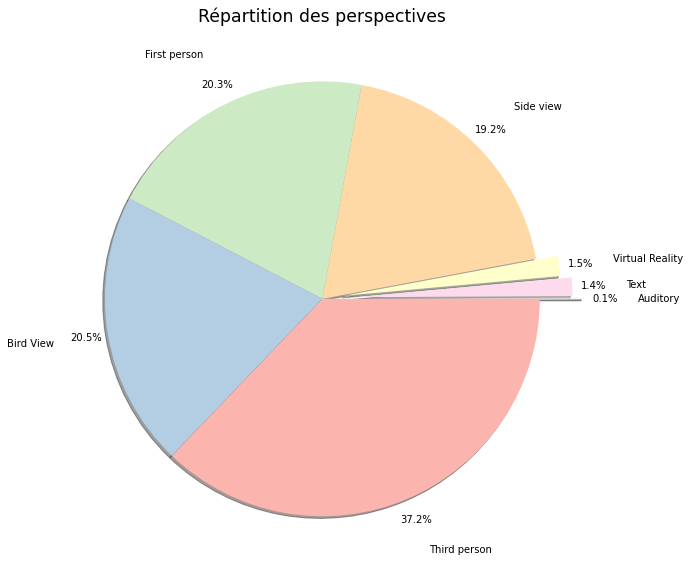

In [42]:
colonnes_cam = ['Auditory', 'Bird View', 'First person', 'Side view', 'Text', 'Third person', 'Virtual Reality']
df_cam = DF[colonnes_cam].sum().sort_values()
myexplode = [0.4, 0.3, 0.2, 0,0,0,0]
dégradé7 = ['#bdd7e7','#eff3ff','#deebf7','#c6dbef','#9ecae1', '#5a9bd4','#1f78b4' ]

colors = plt.cm.Pastel1_r(np.linspace(0, 1, len(df_cam)))

plt.figure(figsize=(5,5))
plt.pie(df_cam, labels=df_cam.index, explode=myexplode,autopct='%1.1f%%',startangle=0,pctdistance=1.1, 
        labeldistance=1.25, colors=colors, radius=2, shadow=True)


plt.title('Répartition des perspectives', y=1.5,fontsize= 'xx-large')
plt.show()


On voit ici que les jeux sont assez inégalement répartis en terme de perspective: il y a presque 2x plus de jeux avec une vue à la 3e personne que de jeux avec une vue la 1e personne, une vue du dessus ou de côté. 
On voit qu'il y a très peu de jeux en VR, ce qui est normale puisque cette technologie est encore en développement. 
En ce qui concerne les jeux de type 'Text' et 'Auditory', on voit qu'il y en a aussi très peu dans notre base de données. Ce n'est pas très étonnant car il s'agit de jeux assez spécifiques. 

Etudions aussi la répartition des différents types (genres) de jeux. Il peut s'agir de jeux de combat, de FPS, de course, de sport, de stratégies, de RPG, etc. Mais il peut aussi y avoir des genres plus 'niche':

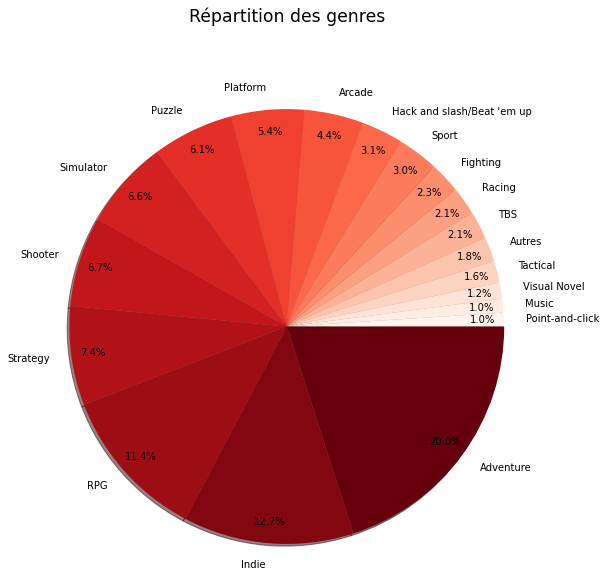

In [43]:
colonnes_cam=list(genre_dictionnary.values())

df_cam = DF[colonnes_cam].sum().sort_values()
dfbis=pd.DataFrame(df_cam)
autres_genres=dfbis[dfbis[0]/dfbis[0].sum()<0.01].index
dfbis.loc['Autres']=dfbis.loc[autres_genres, 0].sum()
dfbis=dfbis.drop(autres_genres)
dfbis=dfbis.sort_values(by=0)

colors = plt.cm.Reds(np.linspace(0, 1, len(dfbis)))

plt.figure(figsize=(5,5))
plt.pie(dfbis[0], labels=dfbis.index,autopct='%1.1f%%',startangle=0,pctdistance=0.9, 
        labeldistance=1.1,colors=colors, radius=2, shadow=True)


plt.title('Répartition des genres', y=1.6,fontsize= 'xx-large')
plt.show()


On voit qu'il y a une grande diversité de genres de jeux. Il y a presque un quart de jeux de type 'Adventure', ie d'un jeu où on suit les pérégrinations d'un personnage principal sur une grande map (type RedDeadRedemption ou Zelda). Les jeux 'Indie' ie indépendants sont également en assez grande proportion: il s'agit de jeux développés par des petites équipes, non financés par des gros studios, donc qui proposent des genres alternatifs avec un gameplay innovant, que l'on ne peut pas vraiment placer dans un genre classique. Mis à part les jeux de type aventure et indépendants, on voit que les différents genres sont assez bien répartis. 

NB: la part 'Autres' du camembert contient des jeux de type Pinball, 
MOB, 
Quiz/Triv, 1
Card & Board Games, dont la proportion au sein du dataframe était trop faible pour en faire des parts distinctes dans le camembert.    

Il peut aussi être intéressant d'étudier la répartition des thèmes des jeux.

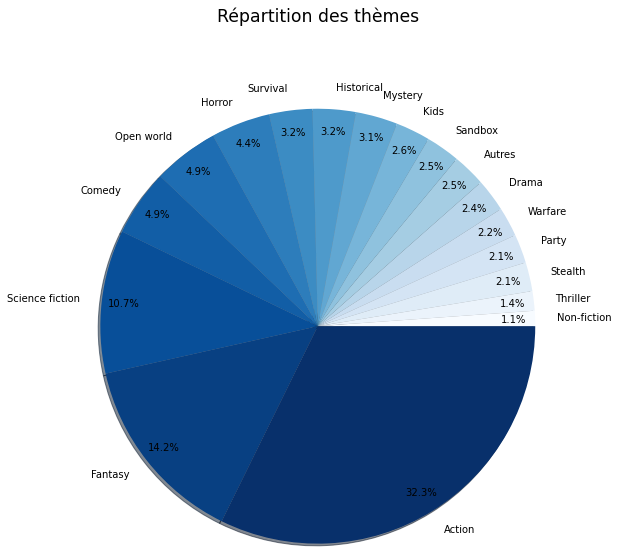

In [44]:
colonnes_cam=list(theme_dictionnary.values())

df_cam = DF[colonnes_cam].sum().sort_values()
dfbis=pd.DataFrame(df_cam)
autres_themes=dfbis[dfbis[0]/dfbis[0].sum()<0.01].index
dfbis.loc['Autres']=dfbis.loc[autres_themes, 0].sum()
dfbis=dfbis.drop(autres_themes)
dfbis=dfbis.sort_values(by=0)

colors = plt.cm.Blues(np.linspace(0, 1, len(dfbis)))

plt.figure(figsize=(5,5))
plt.pie(dfbis[0], labels=dfbis.index,autopct='%1.1f%%',startangle=0,pctdistance=0.9, 
        labeldistance=1.1,colors=colors, radius=2, shadow=True)


plt.title('Répartition des thèmes', y=1.6,fontsize= 'xx-large')
plt.show()

On observe également une grande diversité de thèmes, même si les jeux d'action, fantasy et science fiction sont en proportion plus importante. 
La part 'Autres' du camembert rassemble les jeux de type 4X, d'écudaction, de business, de non-fiction ainsi que les jeux érotiques (!) qui sont en proportion trop faible pour en faire des parts distinctes dans le camembert.

En ce qui concerne la répartition des développeurs principaux: on reprend la liste 'developpeurs' qu'on avait conçue lors de la création des booléens des développeurs. 

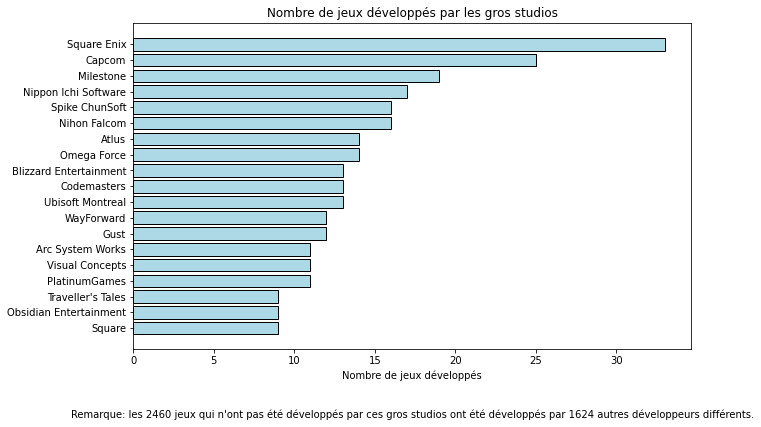

In [45]:
compteur = Counter(developpeurs)


dev_frequents20 = compteur.most_common(20)

noms, freq = zip(*dev_frequents20[1:])

plt.figure(figsize=(10, 6))
plt.barh(noms, freq, color='lightblue',edgecolor='black')
plt.xlabel('Nombre de jeux développés')
plt.title('Nombre de jeux développés par les gros studios')
plt.gca().invert_yaxis() 


nombre_autres_jeux=len(DF)-sum(freq)
nombre_autres_dev=len(set(developpeurs))-20
remarque ='Remarque: les ' + str(nombre_autres_jeux) + ' jeux qui n\'ont pas été développés par ces gros studios ont été développés par ' + str(nombre_autres_dev) + ' autres développeurs différents.'
plt.text(0.5, -0.2, remarque, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10, color='black')

plt.show()

On voit que les gros studios comme Capcom, Square Enix, etc. ont développé plusieurs dizaines de jeux vidéos présents dans notre base. Néanmoins, la base est très fournie et les 20 plus gros studios n'ont en fait développé que 277 des 2737 jeux dans la base. Les 2460 jeux restants ont donc été développés par des plus petits studios, ce qui est à mettre en lien avec la forte proportion de jeux 'indie' qu'on a pu observer dans les genres des jeux. 

Notre base de données est donc éclatée entre une multitude de différents producteurs, puisque le plus gros producteur (Square Enix) n'a produit que 33 des 2737 jeux de la base, soit 1,2% des jeux.


 Qu'en est-il des producteurs de ces jeux vidéos ?

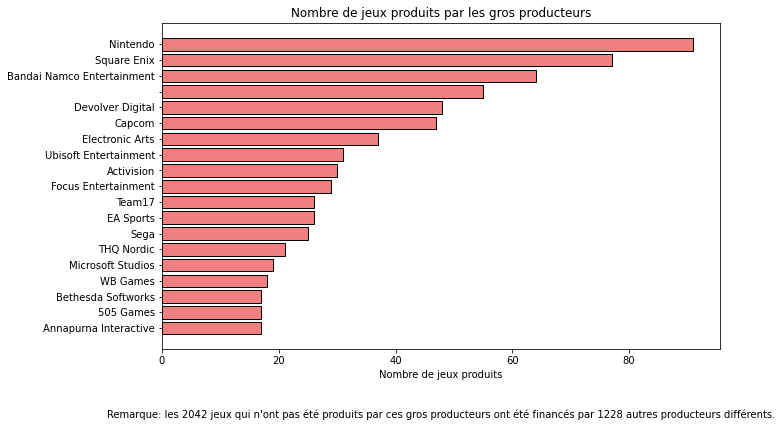

In [46]:
#idem, on recycle la liste 'publishers' qu'on avait créé avant pour concevoir les booléens des gros producteurs.
compteur = Counter(publishers)

prod_frequents20 = compteur.most_common(20)
prodfrequents20=prod_frequents20[:3]+prod_frequents20[4:] 
noms, freq = zip(*prodfrequents20)

plt.figure(figsize=(10, 6))
plt.barh(noms, freq, color='lightcoral',edgecolor='black')
plt.xlabel('Nombre de jeux produits')
plt.title('Nombre de jeux produits par les gros producteurs')
plt.gca().invert_yaxis() 


nombre_autres_jeux=len(DF)-sum(freq)
nombre_autres_dev=len(set(publishers))-20
remarque ='Remarque: les ' + str(nombre_autres_jeux) + ' jeux qui n\'ont pas été produits par ces gros producteurs ont été financés par ' + str(nombre_autres_dev) + ' autres producteurs différents.'
plt.text(0.5, -0.2, remarque, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10, color='black')

plt.show()

Par rapport aux développeurs, on voit que le nombre de jeux produits par des gros producteurs est un peu plus élevé, puisque les 20 plus gros producteurs ont produit chacun entre 17 et 91 jeux. Néanmoins, il y a encore cette fois-ci 2042 jeux qui ont été produits par des plus petits producteurs, au nombre de 1228. 

De même, la base de données est très éclatée entre les différents développeurs, car Nintendo, le plus gros producteur de la base, n'a produit que 91 jeux, soit 3,3% des jeux de la base.


Une autre variable qui peut être intéréssante à visualiser est l'age rating, subdivise les jeux en 3 catégories: 
tout public, pegi 16 et pegi 18.

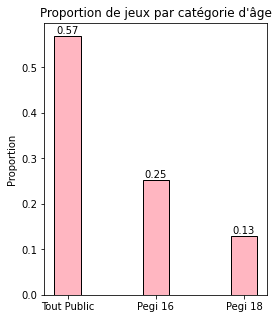

In [47]:
Ages = [('Tout Public',sum(DF['Tout Public']==1)/len(DF)),
        ('Pegi 16',sum(DF['16 year']==1)/len(DF)),
        ('Pegi 18',sum(DF['18 year']==1)/len(DF))]

categories_age, proportions = zip(*Ages)

plt.figure(figsize=(4,5))
bars = plt.bar(categories_age, proportions, width=0.3, color='lightpink', edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')


plt.ylabel('Proportion')
plt.title('Proportion de jeux par catégorie d\'âge')
plt.show()


On voit que 57% des jeux sont classés 'tout public': cela semble normal car les producteurs n'ont en général pas intérêt à faire des jeux pour un public restreint. Seulement 25% des jeux sont classés pegi 16 et 13% des jeux sont pegi 18.

### III/A/2 Répartition des notes des jeux vidéos


On peut maintenant commencer à visualiser la variable qui nous intéresse le plus, à savoir la note metacritic du jeu. Pour commencer, traçons un histogramme de la répartition des notes:

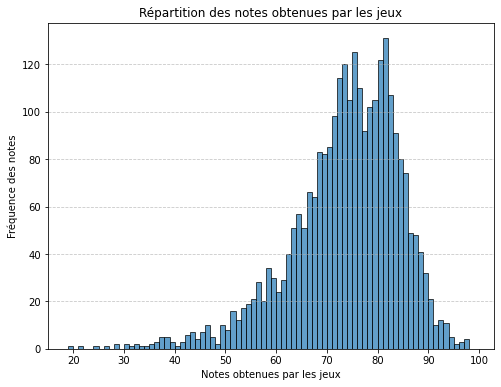

In [48]:

plt.figure(figsize=(8, 6))
plt.hist(DF['Note'], bins=range(int(min(DF['Note'])), 100), edgecolor='black', alpha=0.7)
plt.xlabel('Notes obtenues par les jeux')
plt.ylabel('Fréquence des notes')
plt.title('Répartition des notes obtenues par les jeux')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [49]:
print('la note moyenne est ',DF['Note'].mean())
print('la note médiane est ',DF['Note'].median())
print('les quartiles sont ',DF['Note'].quantile([0.25,0.75]))
print('la note minimum est ',DF['Note'].min(),' elle a été attribuée au jeu ',DF[DF['Note']==DF['Note'].min()]['Title'].to_string(index=False))
print('la note maximum est ',DF['Note'].max(),' elle a été attribuée aux jeux ',DF[DF['Note']==DF['Note'].max()]['Title'].to_string(index=False))

la note moyenne est  73.1611253196931
la note médiane est  75.0
les quartiles sont  0.25    68.0
0.75    81.0
Name: Note, dtype: float64
la note minimum est  19.0  elle a été attribuée au jeu  Alone in the Dark: Illumination
la note maximum est  97.0  elle a été attribuée aux jeux                       Grand Theft Auto V
The Legend of Zelda: Breath of the Wild
                    Super Mario Odyssey
                  Red Dead Redemption 2


D'après notre graphique et les informations ci dessus, il y a une certaine dispersion des notes, entre 19/100 et 97/100. Le jeu ayant obtenu la plus mauvaise note est sans trop de surprise un jeu d'horreur, tandis que ceux qui ont obtenu les meilleures notes sont les iconiques GTA 5, Legend of Zelda, Super Mario Odyssey ainsi que RDR 2.

Même si les notes extrêmes sont très écartées, il y a tout de même une forte concentration des notes des jeux autours de la moyenne, qui est à 73,16/100. En effet, on voit que la note médiane des jeux est à 75/100, et que la moitié des jeux a une note entre 68/100 et 81/100.

Pour continuer dans les statistiques descriptives, nous allons mesure la note moyenne obtenue pour des jeux 'Tout Public', 'Pegi 16' ou 'Pegi 18' de manière à voir si une certaine tendance en ressort. Puis, nous allons faire de même pour les perspectives.

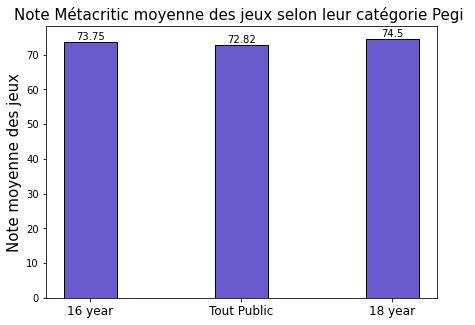

In [50]:
#la liste y_notes_age contient la note moyenne des jeux Tout Public, Pegi 16...
cat1 = list_age_rating
cat2 = list_perspective

y_notes_age = []
for i in cat1 : 
    y_notes_age.append(DF[DF[f'{i}'] == True]['Note'].mean())

y_notes_perspective = []
for j in cat2 : 
    y_notes_perspective.append(DF[DF[f'{j}'] == True]['Note'].mean())

Cat2 = []
sorted_list_perspective = sorted(y_notes_perspective)
for i in sorted_list_perspective : 
    Cat2.append(cat2[y_notes_perspective.index(i)])

x=np.arange(len(y_notes_age))
width= 0.35

fig, ax = plt.subplots(figsize=(7,5))
rects1= ax.bar(x, y_notes_age, width, color='slateblue', edgecolor = "black")

for bar in rects1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

ax.set_ylabel("Note moyenne des jeux", fontsize = 15)
ax.set_title("Note Métacritic moyenne des jeux selon leur catégorie Pegi ", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(cat1, fontsize=12)

plt.show()

La catégorie Pegi du jeu ne semble pas influencer plus que ça la note du jeu: en moyenne, les jeux "tout public" semblent un peu moins bien notés que les jeux "Pegi 16", qui sont eux-même légèrement moins bien notés que les jeux "Pegi 18".

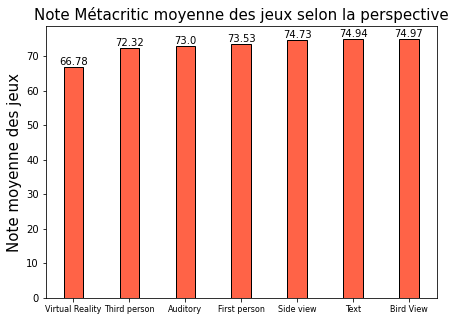

In [51]:
#Pareil ici pour selon la perspective
x = np.arange(len(y_notes_perspective))
width= 0.35

fig, ax = plt.subplots(figsize=(7,5))
rects1= ax.bar(x, sorted_list_perspective, width, color = 'Tomato', edgecolor = "black")
ax.set_ylabel("Note moyenne des jeux", fontsize = 15)
ax.set_title("Note Métacritic moyenne des jeux selon la perspective", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(Cat2, fontsize = 8)

for bar in rects1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')


plt.show()

La perspective du jeu semble un peu plus avoir un impact sur la note du jeu. On voit ici par exemple que ce sont les jeux en réalité virtuelle qui ont les pire notes en moyenne. Cela ne semble pas très étonnant puisqu'il s'agit encore d'une technologie très récente et pas encore au point, donc qui peut facilement décevoir les utilisateurs des jeux.

Il peut aussi être intéressant de voir si le nombre de plateformes sur lequel un jeu est disponible impacte la note du jeu. C'est probable puisque le nombre de plateformes est un proxy du nombre d'utilisateurs du jeu, information à laquelle on n'a pas accès.

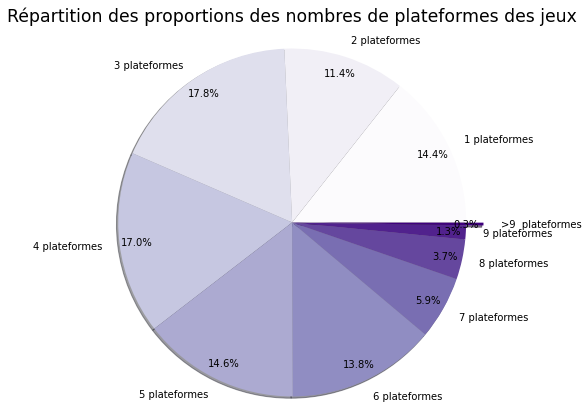

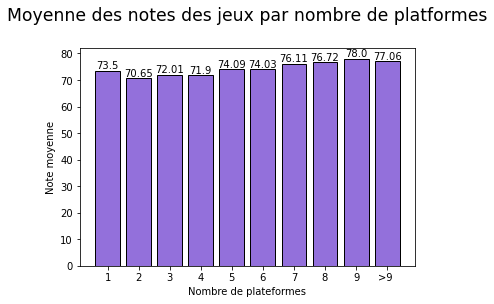

In [52]:
Nbr_platformes = [(i, DF[DF['nb_platforms'] == i]['Note'].count(),DF[DF['nb_platforms'] == i]['Note'].mean()) for i in set(DF["nb_platforms"])]

dfbis=pd.DataFrame(Nbr_platformes)

#on fait d'abord un camembert qui montre que les jeux étant présents sur plus de 10 plateformes sont en très faible proportion
autresprop=dfbis[dfbis[1]/dfbis[1].sum()<0.01].index
dfbis.loc['>9 ']=dfbis.loc[autresprop].mean()
dfbis=dfbis.drop(autresprop)
dfbis['indexbis'] = dfbis.index.astype(str) + ' plateformes'
dfbis['indexbisbis'] = dfbis.index.astype(str)

myexplode=np.zeros(len(dfbis))
myexplode[len(dfbis)-1]=0.2
colors = plt.cm.Purples(np.linspace(0, 1,len(dfbis)))

plt.figure(figsize=(4,4))
plt.pie(dfbis[1],labels=dfbis['indexbis'], explode=myexplode, autopct='%1.1f%%',startangle=0,pctdistance=0.9, 
        labeldistance=1.1,colors=colors, radius=2, shadow=True)

plt.title('Répartition des proportions des nombres de plateformes des jeux', y=1.4,fontsize= 'xx-large')
plt.show()


#on peut ensuite tracer le barplot des notes moyennes en fonction du nombre de plateformes
plt.figure()
bars = plt.bar(dfbis['indexbisbis'], dfbis[2], color = 'mediumpurple', edgecolor = 'black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')


plt.xlabel('Nombre de plateformes')
plt.ylabel('Note moyenne')
plt.title('Moyenne des notes des jeux par nombre de platformes',y=1.1,fontsize= 'xx-large')
plt.show()

Une tendance semble se dégager: plus le jeu est accessible sur un nombre élevé de plateformes, plus sa note semble élevée. On peut se permettre de ne pas prendre en compte les jeux accessibles sur plus de 9 plateformes, car le camembert montre que leur proportion est totalement anectodique. Comme le nombre de plateformes est un proxy du nombre d'utilisateurs du jeu, il semble que la note du jeu est croissante avec le nombre d'utilisateurs: ceci est plutôt logique car si il y a beaucoup d'utilisateurs, c'est que le jeu est populaire donc probablement de bonne qualité.

Il est aussi intéressant de voir comment les notes des jeux sont réparties en fonction de leur thème et leur genre: il est en effet fort probable que certains thèmes/genres obtiennent en moyenne de meilleures moyennes que d'autres.

/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_27554/849653388.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(themes_liste[0],rotation=45, ha='right')


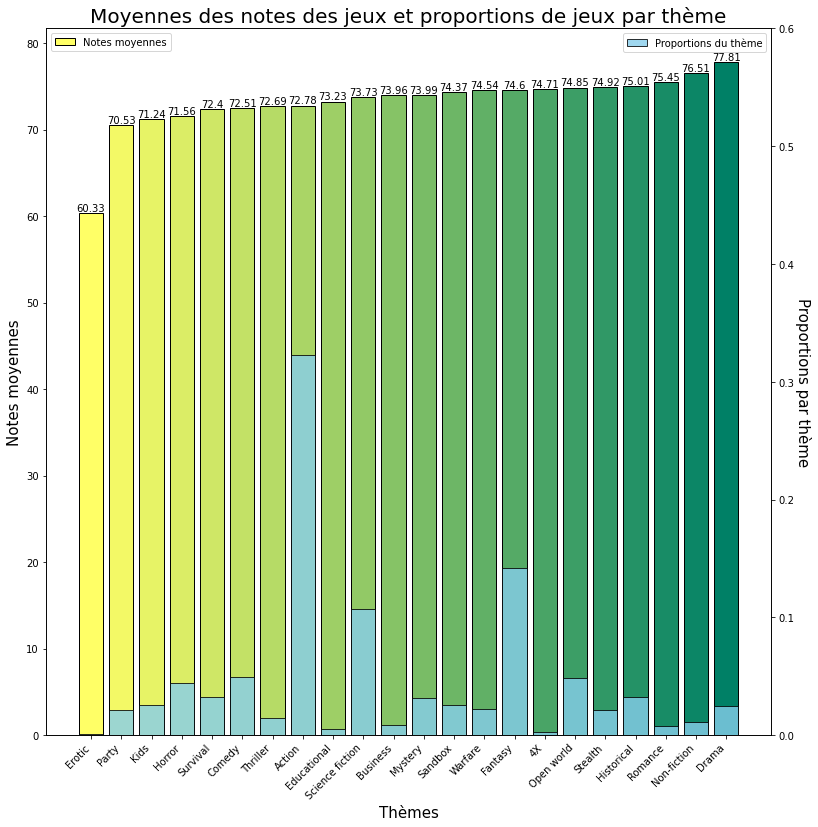

In [53]:
themes_liste = [(str(i), DF[DF[i] == 1]['Note'].mean(),DF[i].sum()) for i in list(theme_dictionnary.values())]

themes_liste=pd.DataFrame(themes_liste)
themes_liste[2]=themes_liste[2]/themes_liste[2].sum()
themes_liste = themes_liste.sort_values(by=1)

fig, ax1 = plt.subplots(figsize=(13,13))

colors = plt.cm.summer_r(np.linspace(0, 1, len(themes_liste)))

bars = ax1.bar(themes_liste[0], themes_liste[1], color=colors, edgecolor='black', label='Notes moyennes')

ax1.set_xticklabels(themes_liste[0],rotation=45, ha='right') 
ax1.set_xlabel('Thèmes',fontsize='15')
ax1.set_ylabel('Notes moyennes',fontsize='15')
ax1.set_title('Moyennes des notes des jeux et proportions de jeux par thème',fontsize='20')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# on créé un deuxième axe pour les proportions
ax2 = ax1.twinx()
ax2.bar(themes_liste[0], themes_liste[2], color='skyblue', alpha=0.8, edgecolor='black', label='Proportions du thème')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax2.set_yticks(np.arange(0, 0.7, 0.1))
ax2.set_ylabel('Proportions par thème',fontsize='15',rotation=270)
ax2.yaxis.set_label_coords(1.055, 0.5)

plt.show()

/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_27554/679507804.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(genre_liste[0],rotation=45, ha='right')


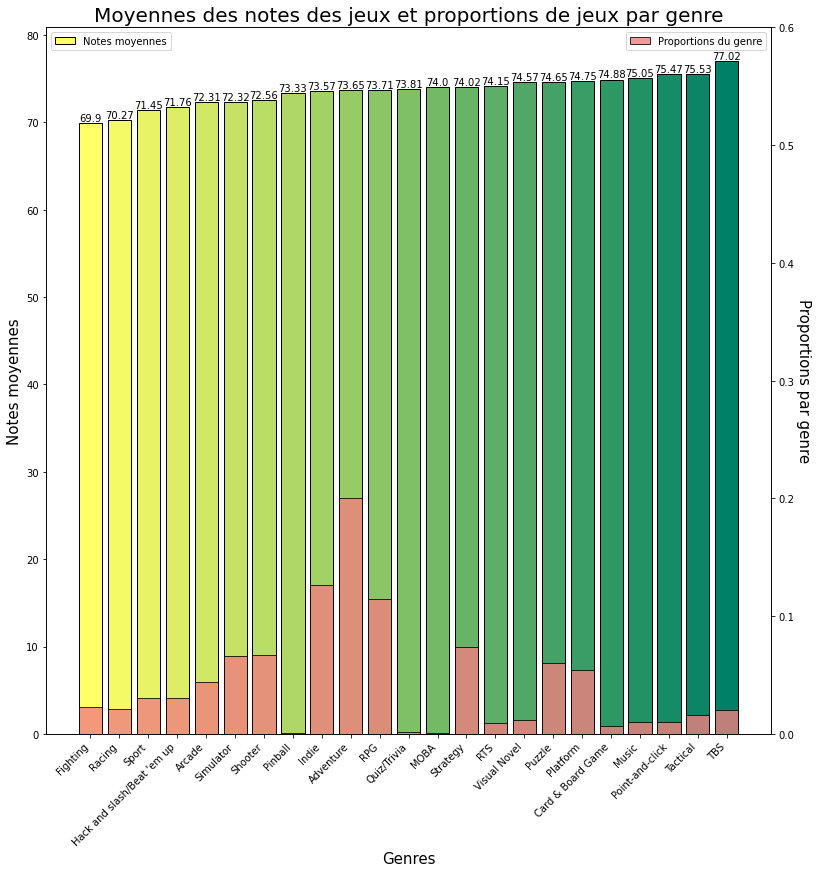

In [54]:
genre_liste = [(str(i), DF[DF[i] == 1]['Note'].mean(),DF[i].sum()) for i in list(genre_dictionnary.values())]

genre_liste=pd.DataFrame(genre_liste)
genre_liste[2]=genre_liste[2]/genre_liste[2].sum()
genre_liste = genre_liste.sort_values(by=1)

fig, ax1 = plt.subplots(figsize=(13,13))

colors = plt.cm.summer_r(np.linspace(0, 1, len(genre_liste)))

bars = ax1.bar(genre_liste[0], genre_liste[1], color=colors, edgecolor='black', label='Notes moyennes')

ax1.set_xticklabels(genre_liste[0],rotation=45, ha='right') 
ax1.set_xlabel('Genres',fontsize='15')
ax1.set_ylabel('Notes moyennes',fontsize='15')
ax1.set_title('Moyennes des notes des jeux et proportions de jeux par genre',fontsize='20')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# on créé un deuxième axe pour les proportions
ax2 = ax1.twinx()
ax2.bar(genre_liste[0], genre_liste[2], color='lightcoral', alpha=0.8, edgecolor='black', label='Proportions du genre')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax2.set_yticks(np.arange(0, 0.7, 0.1))
ax2.set_ylabel('Proportions par genre',fontsize='15',rotation=270)
ax2.yaxis.set_label_coords(1.055, 0.5)

plt.show()

On voit en effet que les jeux ont en moyenne des notes différents en fonction de leur thèmes/genre.

-Pour les thèmes : les jeux qui obtiennent en moyenne des meilleures notes sont ceux de theme 'Drama', tandis que ceux qui recoivent en moyenne les moins bonnes notes sont ceux de thème 'erotic', ce qui n'est pas très surprenant car on voit mal comment un jeu de ce type peut être de bonne qualité.

-pour les genres: les jeux qui obtiennent en moyenne les meilleures notes sont ceux de type TBS (jeux de stratégie type 'warhammer 40k') tandis que ceux qui obtiennent en moyenne les moins bonnes notes sont les jeux de combat 'fighting'

Il faut toutefois remarquer que les thèmes/genres de jeux qui obtiennent les meilleures notes moyennes sont en faible proportion au sein de la base de donnée (cf les barres rouges sur les diagrammes). Par exemple, le fait que les jeux de type 'Romance' aient une excellente moyenne peut être biaisé par le fait qu'il y a peu de jeux de ce type dans la base, et que la moyenne est boostée par un ou deux jeux ayant obtenu une excellente note.

Enfin, on peut voir comment les notes des jeux sont réparties en fonction de leur producteur/développeur, et donc de leur budget. 

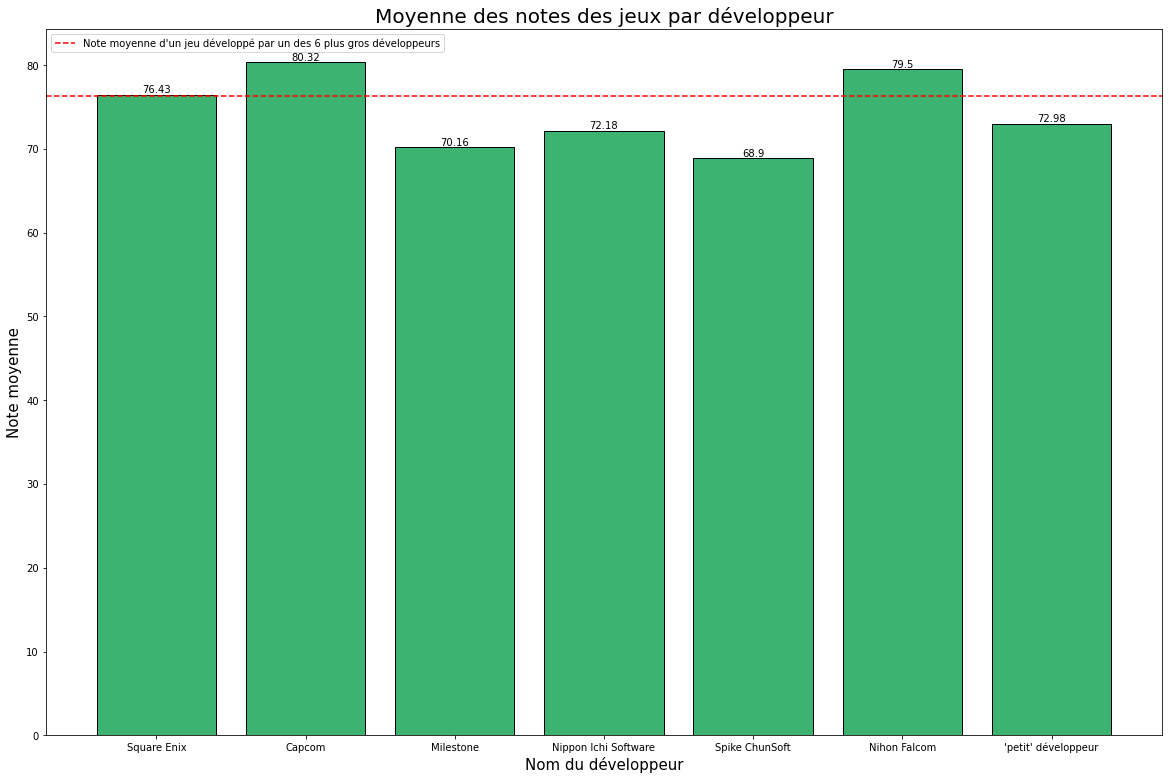

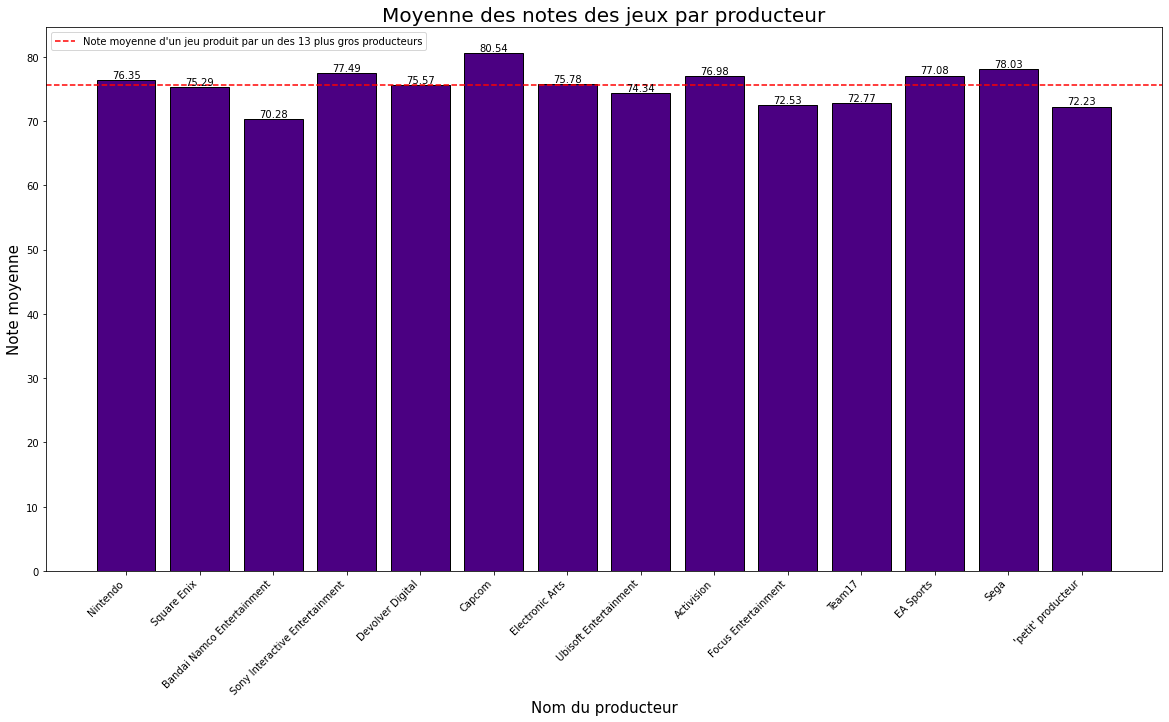

In [55]:
##pour les développeurs 

dev = [(str(i), DF[DF[i] == 1]['Note'].mean()) for i in list(dev_frequents)]
autres = [('\'petit\' développeur', DF[DF['Autre développeur']==1]['Note'].mean())]
dev=dev + autres
dev=pd.DataFrame(dev) 

plt.figure(figsize=(20,13))
bars= plt.bar(dev[0], dev[1], color = 'mediumseagreen',edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.axhline(y=np.mean(dev[1][5:]), color='red', linestyle='--', label='Note moyenne d\'un jeu développé par un des 6 plus gros développeurs')
plt.legend(loc='upper left')

plt.ylabel('Note moyenne',fontsize= 15)
plt.xlabel('Nom du développeur',fontsize = 15)
plt.title('Moyenne des notes des jeux par développeur',fontsize=20)
plt.show()

##pour les producteurs 

prod = [(str(i), DF[DF[str(i) + ' producteur'] == 1]['Note'].mean()) for i in list(prod_frequents)]
autres = [('\'petit\' producteur', DF[DF['Autre producteur']==1]['Note'].mean())]
prod=prod + autres
prod=pd.DataFrame(prod)

plt.figure(figsize=(20,10))
bars= plt.bar(prod[0], prod[1], color = 'indigo',edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.axhline(y=np.mean(prod[1][:13]), color='red', linestyle='--', label='Note moyenne d\'un jeu produit par un des 13 plus gros producteurs')
plt.legend(loc='upper left')

plt.ylabel('Note moyenne',fontsize= 15)
plt.xlabel('Nom du producteur',fontsize = 15)
plt.xticks(prod[0], rotation=45, ha='right')
plt.title('Moyenne des notes des jeux par producteur',fontsize=20)
plt.show()

On voit qu'en moyenne, les jeux des 6 plus gros développeurs (ceux qui ont développé plus de 15 jeux) obtiennent de meilleures notes que les jeux des 'petits' développeurs (ceux qui ont développé moins de 15 jeux). Etonnamment, il apparait que certains gros développeurs produisent des jeux qui ont des notes médiocres en moyenne. C'est notamment le cas de Spike Chunsoft, 4e plus gros développeur de la base.

Est-ce parce que même si c'est un gros développeur, il n'alloue pas un gros budget à chacun des jeux qu'il créé ? Ou bien peut-être que c'est parce qu'il s'agit d'un développeur spécialisé dans un certain type de jeu qui a en moyenne d'assez mauvaises notes ? Il serait intéressant de pousser l'analyse en regardant quels sont les notes moyennes chez les développeurs pour un type de jeu en particulier (par exemple fighting, le type de jeu le moins bien noté) mais on ne dispose pas d'assez de jeux dans la base produits par les gros développeurs pour pouvoir obtenir des résultats pertinents.

On peut faire les mêmes observations pour les producteurs: les 13 plus gros producteurs (ceux ayant financé plus de 25 jeux) obtiennent en moyenne de meilleures notes que les jeux des 'petits développeurs'. Toutefois, certains gros producteurs produisent également des jeux ayant en moyenne des notes peu satisfaisantes, comme Bandai Namco Entertainement.

Dans cette partie, nous avons visualisé nos données et avons quelques constats sur l'impact des différentes variables sur la note. On a notamment pu voir que nos données sont très éclatées entre les différents types de jeu vidéos (notamment en terme de genre, de thème, de perspective, de producteur et développeur, de public concerné, etc). Et que chaque type de jeu vidéo a une note différente en moyenne. En particulier, les genres/thèmes, les producteurs/développeurs, la perspective du jeu, le nombre de plateformes sur lequel le jeu est disponible ont clairement un impact sur la note du jeu.

Nous allons désormais pouvoir quantifier cette corrélation entre les variables.

# III/B Corrélations entre les variables 

### III/B/1 Corrélations 

Commençons par représenter la matrice des corrélations de nos variables sous forme d'une heatmap. Pour réaliser cela, nous devons prendre uniquement en compte les variables chiffrées.  

In [56]:
#on se débarasse donc des variables non chiffrées
dfheatmap= DF.drop(['index','Title','Similar Games','Id','Summary','Storyline'],axis=1)

for i in dfheatmap.columns: 
    dfheatmap[i] = pd.to_numeric(dfheatmap[i], errors='coerce')

<AxesSubplot:>

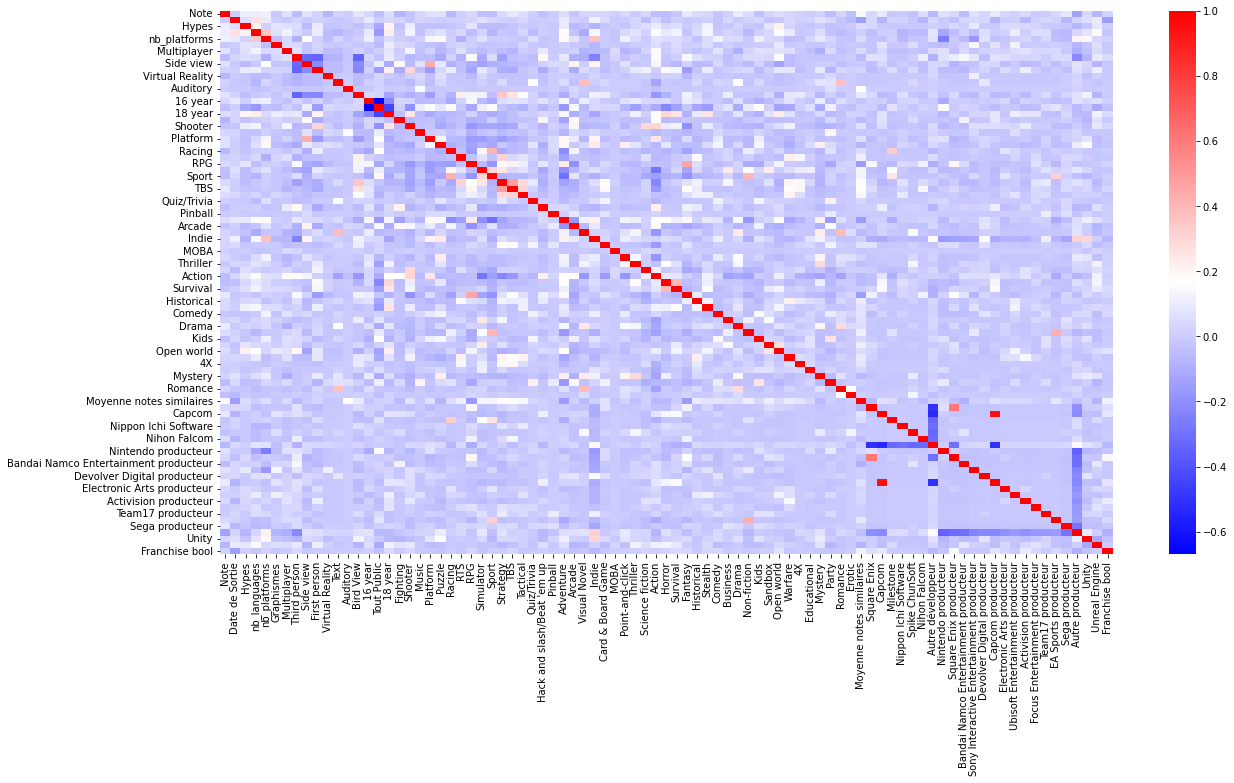

In [57]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(dfheatmap.corr(), cmap='bwr')

Etant donné qu'on dispose de 86 variables à inclure dans notre heatmap, on ne voit pas grand chose quand on représente l'intégralité des variables sur la heatmap. On ne peut donc pas interpréter quoique ce soit. \
Il est donc judicieux d'utiliser une autre heatmap avec laquelle on peut zoomer. Sur la heatmap suivante, tous les noms des variables ne sont pas inscrits en abscisse et ordonnées, néanmoins elles sont toutes représentées et on peut voir que toutes les corrélations entre toutes les variables sont présentes sur la heatmap en zoomant. 

In [58]:
fig = px.imshow(dfheatmap.corr(), title='Heatmap du Dataframe', color_continuous_scale='Picnic', width=800, height=800)

fig.show()

En promenant le curseur de la souris sur la heatmap pour zoomer, il apparait que les variables les plus corrélées à la note du jeu sont : \
-hypes, ie l'indicatrice de si le jeu a fait l'objet d'un fort engouement auprès du public avant sa sortie. \
-nb_platforms, ie le nombre de plateformes sur lequel le jeu est disponible. \
-nb_languages, ie le nombre de languages disponibles sur le jeu (un bon proxy du nombre d'utilisateurs du jeu, tout comme nb_plateformes). \
-Drama, ie l'indicatrice de si le jeu est du genre 'Drama' ou pas. \
-Notes similaires, ie les notes des jeux similaires \
-Autre producteur, ie l'indicatrice de si le jeu est produit par un 'petit' producteur ( = qui a produit moins de 25 jeux de la base). 

Ces variables sont toutes corrélées de façon positive avec la note, mis à part la variable 'autre producteur': cela nous permet donc de supposer que les petits producteurs ont peu de budget et produisent en moyenne des jeux obtenant de moins bonnes notes que ceux des gros producteurs, pour cette raison.  \
On peut supposer que un jeu disponible un nombre de plateformes et en beaucoup de languages différents (donc un jeu accessible à un large public) a des meilleures notes en moyenne.  De même, un jeu de type Drama, ou un jeu ayant généré beaucoup de hype avant sa sortie aura une meilleure note en moyenne. 


Confirmons ces observations sur la corrélation autremement:

In [59]:
matricecorr = dfheatmap.corr()

for var in matricecorr.columns:
    if abs(matricecorr.loc[var, 'Note']) >= 0.1 and var != 'Note':
        print(f"Corrélation entre {var} et Note: {matricecorr.loc[var, 'Note']}")

Corrélation entre Hypes et Note: 0.1011218616778016
Corrélation entre nb_languages et Note: 0.1065983508624507
Corrélation entre nb_platforms et Note: 0.11828125648714018
Corrélation entre Drama et Note: 0.10058784854557515
Corrélation entre Moyenne notes similaires et Note: 0.14268104095914944
Corrélation entre Autre producteur et Note: -0.13791211041605292


Tout cela nous permet de confirmer l'hypothèse que parmi les catégories de caractéristiques que nous avons identifié au début du projet, les suivantes sont corrélées au succès du jeu : 
-l'engouement autour du jeu, représenté par la variable 'Hypes'


Les autres variables qui sont les plus corrélées (mais dans une moindre mesure) à 'Note' sont : 

In [60]:
matricecorr = dfheatmap.corr()

for var in matricecorr.columns:
    if abs(matricecorr.loc[var, 'Note']) < 0.1 and abs(matricecorr.loc[var, 'Note']) > 0.07 and var != 'Note':
        print(f"Corrélation entre {var} et Note: {matricecorr.loc[var, 'Note']}")

Corrélation entre Bird View et Note: 0.08053214740650855
Corrélation entre Fighting et Note: -0.08126982863626207
Corrélation entre TBS et Note: 0.09021929568566775
Corrélation entre Fantasy et Note: 0.08711467782857768
Corrélation entre Capcom et Note: 0.09106103040197464
Corrélation entre Capcom producteur et Note: 0.09938482037841256
Corrélation entre Sega producteur et Note: 0.08185495798959497
Corrélation entre Unreal Engine et Note: -0.07202364893891218


Les autres variables les plus corrélées à 'Note' sont donc:\
-bird view, ie une variable qui indique que la perspective du jeu est une vue du dessus.  \
-Fighting et TBS, des variables indiquant le genre du jeu (cela confirme ce qu'on avait observé avec les graphiques précédents).\
-Fantasy, une variable qui indique un type de thème. \
-Capcom, Capcom producteur, Sega producteur, des variables qui indiquent que le jeu a été développé et financé par le studio Capcom (ou Sega).\
-Unreal Engine, qui indique que le jeu a été développé sur ce logiciel. 

Les variables corrélées négativement à 'Note' sont ici Fighting et Unreal Engine. 


### III/B/2 Régressions simples

# IV/ MODÉLISATION

Dans cette partie nous allons utiliser diverses techniques d'analyse statistique afin d'essayer de prédire au mieux les notes des jeux à partir des variables que nous avons dans la base. 

## A/ Régressions

Dans cette partie, nous allons tester plusieurs types de régressions (pénalisées ou non) sur notre dataframe afin de comparer les capacités prédictives des différents modèles. 

1/ Tout d'abord, nous allons travailler avec un dataframe plus propre : 

    - nous allons donc utiliser une technique d'imputation utilisant l'algorithme dans K plus proches voisins afin d'imputer les valeurs manquantes dans la colonne 'graphismes' et 'Date de Sortie'. 

    - nous n'utilisons que les covariables quantitatives de notre dataframe
    
    - nous allons centrer et réduire nos données 


In [83]:
DF_copie = DF.copy()

DF_copie.drop(['index', 'Note', 'Title', 'Id', 'Summary', 'Storyline', 'Similar Games'], axis = 1, inplace = True)

#la méthode d'imputation que nous allons utiliser par la suite ne fonctionne que sur des valeurs NaN
DF_copie['Graphismes'].replace({'NA' : np.nan}, inplace = True)
#On remplace 1970 par un NaN dans la colonne Date de Sortie parce qu'il s'agit de la valeur par défaut attribuée dans la base si jamais 
#l'information est manquante
DF_copie['Date de Sortie'].replace({1970 : np.nan}, inplace = True)


On remarque que certains jeux n'ont pas de donnée dans le colonne 'graphismes' et 'date de sortie'. Nous allons utiliser le package fancyimpute afin d'imputer la valeur des graphismes avec l'algorithme des K-voisins. Le but étant de pouvoir utiliser cette colonne dans nos modèles alors même que beaucoup de valeurs sont manquantes. 

De plus, cette méthode permet de ne pas introduire de biais et fausser l'analyse en composante principale par rapport aux méthodes plus simples comme le fait de remplacer les NA par la moyenne des valeurs dans la colonne. 

In [84]:
imputer = KNN(k= 5)
DF_imputed = imputer.fit_transform(DF_copie)
DF_imputed = pd.DataFrame(DF_imputed)

Imputing row 1/2737 with 0 missing, elapsed time: 3.086
Imputing row 101/2737 with 0 missing, elapsed time: 3.087
Imputing row 201/2737 with 0 missing, elapsed time: 3.088
Imputing row 301/2737 with 1 missing, elapsed time: 3.090
Imputing row 401/2737 with 0 missing, elapsed time: 3.091
Imputing row 501/2737 with 0 missing, elapsed time: 3.091
Imputing row 601/2737 with 0 missing, elapsed time: 3.093
Imputing row 701/2737 with 0 missing, elapsed time: 3.094
Imputing row 801/2737 with 0 missing, elapsed time: 3.095
Imputing row 901/2737 with 0 missing, elapsed time: 3.096
Imputing row 1001/2737 with 0 missing, elapsed time: 3.097
Imputing row 1101/2737 with 0 missing, elapsed time: 3.097
Imputing row 1201/2737 with 0 missing, elapsed time: 3.098
Imputing row 1301/2737 with 0 missing, elapsed time: 3.098
Imputing row 1401/2737 with 0 missing, elapsed time: 3.099
Imputing row 1501/2737 with 0 missing, elapsed time: 3.100
Imputing row 1601/2737 with 0 missing, elapsed time: 3.101
Imputing 

Ici nous centrons et réduisant nos données pour limiter un éventuel effet d'échelle

In [85]:
scaler = StandardScaler()
DF_scaled = scaler.fit_transform(DF_imputed)
DF_scaled = pd.DataFrame(DF_scaled, columns = DF_imputed.columns)
DF_scaled.columns = DF_copie.columns

2/ Comparaison des différents modèles

On peut commencer par effectuer une simple régression linéaire prédisant la note à partir des covariables numériques, à savoir : 'Note', 'Date de Sortie', 'Hypes', 'nb_languages', 'nb_platforms',  'Franchise bool

In [61]:
#
df2 = DF.select_dtypes(include=['int', 'float']).copy()
df2 = df2.drop("Id", axis=1).drop("index", axis=1).dropna().astype(np.float64)


X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["Note"], axis = 1),
    df2[['Note']].values.ravel(), test_size=0.2, random_state=0
)

ols = LinearRegression().fit(X_train, y_train)
y_pred = ols.predict(X_test)

print("R_2 : " +str(ols.score(X_test, y_test)))

R_2 : 0.01717738784645606


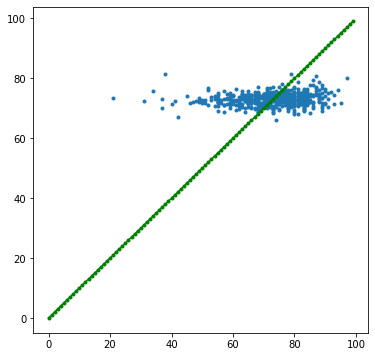

In [62]:

fig, axs = plt.subplots( figsize=(6, 6))

plt.scatter(y_test, y_pred, marker = "." )

plt.plot([x for x in range(100)], color='g', marker = ".", label="y=x")


Sans suprise, la régression est médiocre. Les notes sont toutes concentrées autour de la moyenne, et les paramètres jouent très peu. Essayons de rajouter d'autres paramètres.

R_2 : 0.09768780600128946


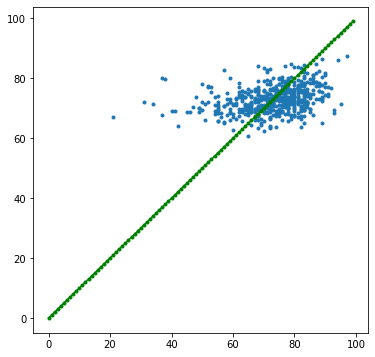

In [63]:

df2 = DF.select_dtypes(include=['int', 'float', 'bool']).copy()
df2 = df2.drop("Id", axis=1).drop("index", axis=1).dropna().astype(np.float64)

#on run le modèle avec les fonctions prebuilt
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["Note"], axis = 1),
    df2[['Note']].values.ravel(), test_size=0.2, random_state=0
)

ols = LinearRegression().fit(X_train, y_train)
y_pred = ols.predict(X_test)




print("R_2 : " +str(ols.score(X_test, y_test)))

fig, axs = plt.subplots( figsize=(6, 6))

plt.scatter(y_test, y_pred, marker = "." )

plt.plot([x for x in range(100)], color='g', marker = ".", label="y=x")


C'est un peu mieux, on passe d'un R_2 de 0.01 à 0.09, et les points sont plus dispersés, mais ce n'est pas non plus exceptionnel. Observons tout de même les coefficients de la régression, pour voir si l'on peut en tirer des informations utiles.

In [64]:
#utilisation de stats_models pour obtenir les coefficients
import statsmodels.api as sm
import statsmodels.formula.api as smf

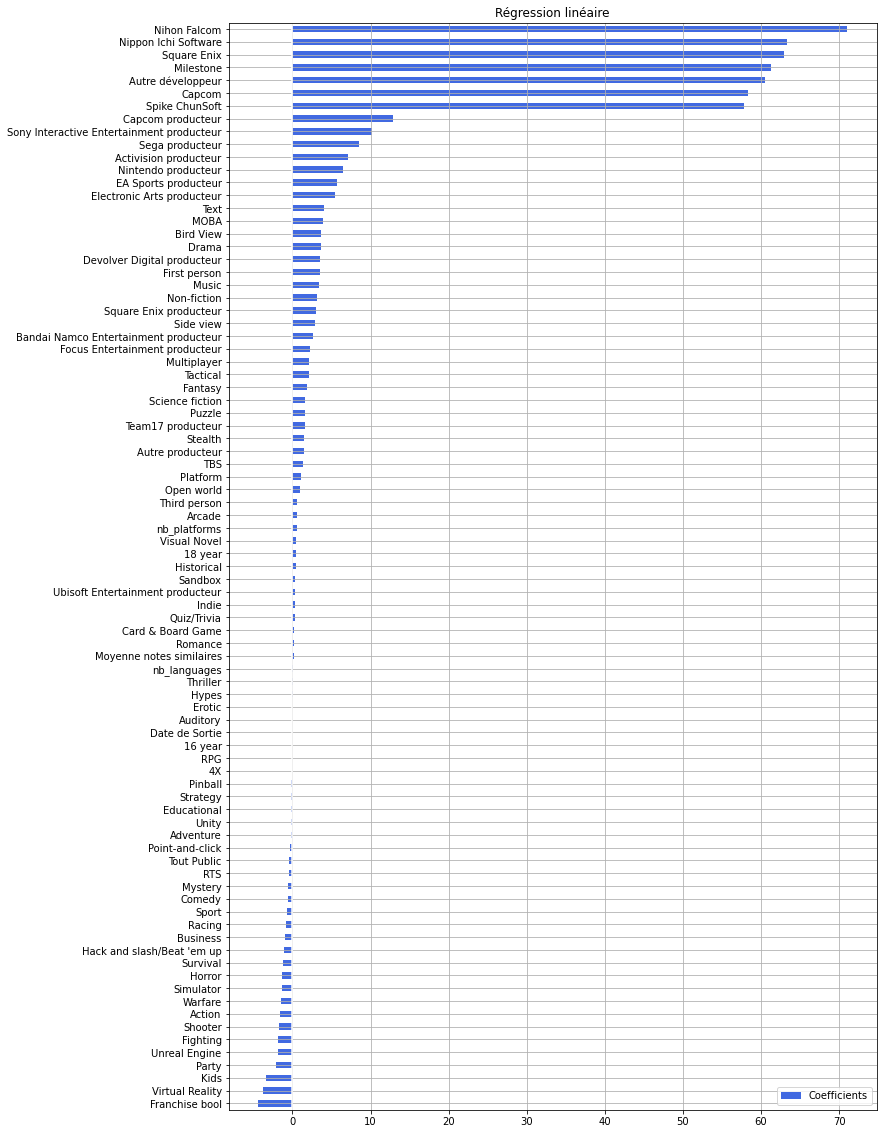

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["Note"], axis = 1),
    df2[['Note']].values.ravel(), test_size=0.2, random_state=0
)


res = sm.OLS(y_train, X_train).fit()
y_pred = res.get_prediction(X_test).predicted_mean
    
coefs = pd.DataFrame(list(res.params),columns=['Coefficients'], index=df2.drop(["Note"], axis = 1).columns)
coefs.sort_values(by='Coefficients', ascending=True, inplace=True)
coefs.plot(kind='barh', figsize=(15, 20), color='royalblue')
plt.title('Régression linéaire')
plt.axvline(x=0, color='1')
plt.grid()
plt.subplots_adjust(left=.3)




   


Il est au moins rassurant de voir que la régression mets bien en évidence le fait que les gros studios ont plus de chance de sortir des jeux appréciés.
Essayons maintenant une régression LASSO car il y a probablement de l'overfitting dans le modèle d'une régression multivariée classique

R_2 : 0.1067841472522294


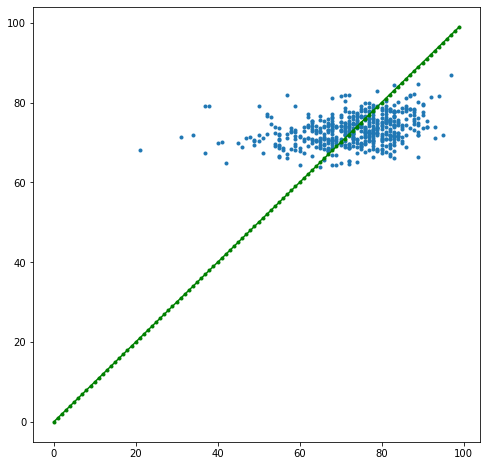

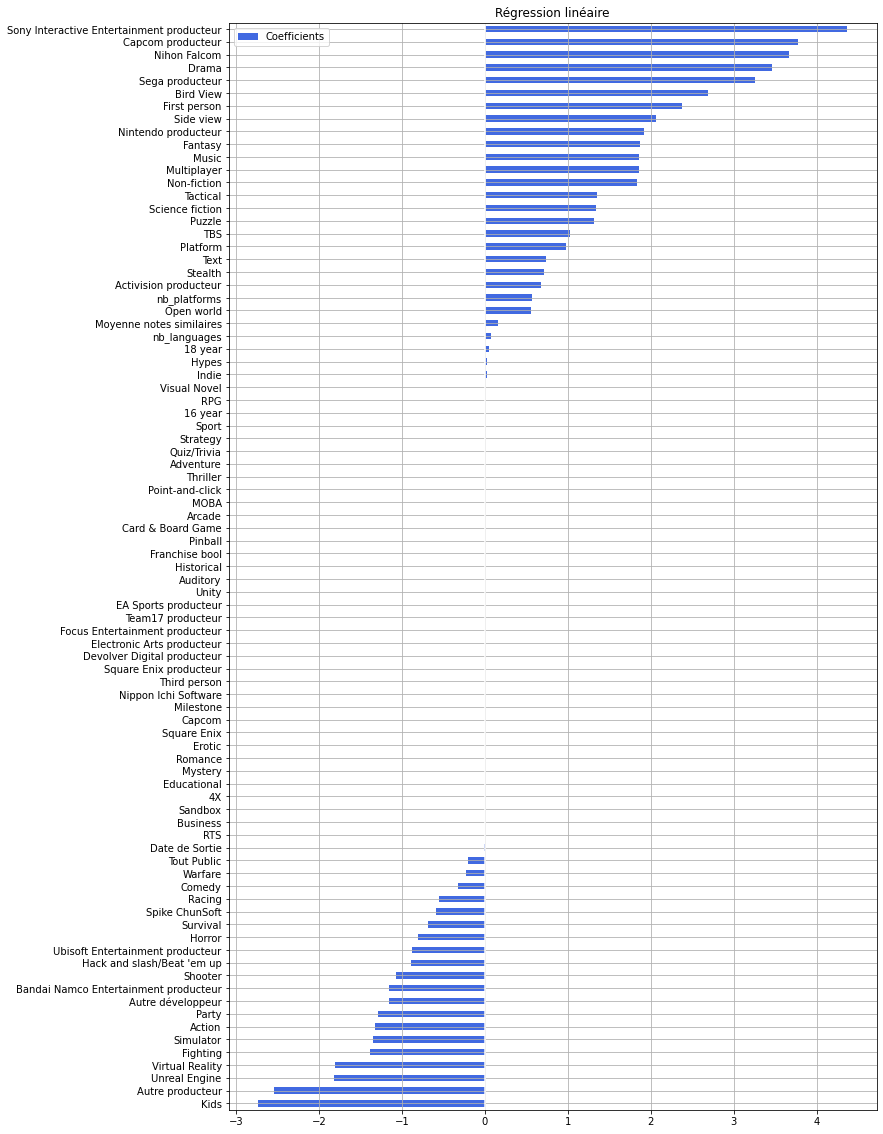

In [66]:
from sklearn.linear_model import Lasso

X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["Note"], axis = 1),
    df2[['Note']].values.ravel(), test_size=0.2, random_state=0
)

model = Lasso(fit_intercept=True, alpha = 0.03)  
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print("R_2 : " +str(model.score(X_test, y_test)))


fig, axs = plt.subplots( figsize=(8, 8))

plt.scatter(y_test, y_pred, marker = "." )

plt.plot([x for x in range(100)], color='g', marker = ".", label="y=x")


coefs = pd.DataFrame(model.coef_,columns=['Coefficients'], index=df2.drop(["Note"], axis = 1).columns)
coefs.sort_values(by='Coefficients', ascending=True, inplace=True)
coefs.plot(kind='barh', figsize=(15, 20), color='royalblue')
plt.title('Régression linéaire')
plt.axvline(x=0, color='1')
plt.grid()
plt.subplots_adjust(left=.3)

En testant différentes valeurs de alpha, on arrive effectivement à augmenter le R_2 jusqu'à 0.106 environ. La valeur des coefficients obtenus est sans doute plus riche en information que la prédiction de la régression, qui est tout simplement trop imprécise. Il est en effet intéressant de constater que des paramètres qui pouvaient sembler très prometteurs, comme Moyenne notes similaires, nb_platformes, ou nb_languages, ne sont au final pas si impactants. Il apparait aussi clairement qu'être un jeu développé par une société est importante est sans surprise un critère de poids. 

## IV/A/ Analyse en Composantes Principales

Le but de cette méthode est de pouvoir transformer des variables très corrélées en de nouvelles variables décorrélées afin de résumer au mieux l'information contenue dans notre Dataframe, tout en réduisant les dimensions. Cette technique peut s'avérer très utile au vu du grand nombre de variables explicatives. 

Tout d'abord, nous n'utiliserons les valeurs non quantitatives de notre dataframe et il nous faut centrer et réduire les variables que nous allons étudier afin de réduire l'effet d'échelle : nous le faisons avec la méthode standardScaler() de Sklearn.preprocessing

In [67]:
DF_copie = DF.copy()

DF_copie.drop(['index', 'Note', 'Title', 'Id', 'Summary', 'Storyline', 'Similar Games'], axis = 1, inplace = True)

#la méthode d'imputation que nous allons utiliser par la suite ne fonctionne que sur des valeurs NaN
DF_copie['Graphismes'].replace({'NA' : np.nan}, inplace = True)

On remarque que certains jeux n'ont pas de donnée dans le colonne graphisme. Nous allons utiliser le package fancyimpute afin d'imputer la valeur des graphismes avec l'algorithme des K-voisins. Cette méthode permet de ne pas introduire de biais et fausser l'analyse en composante principale par rapport aux méthodes plus simples comme le fait de remplacer les NA par la moyenne des valeurs dans la colonne. 

In [68]:
imputer = KNN(k= 5)
DF_imputed = imputer.fit_transform(DF_copie)
DF_imputed = pd.DataFrame(DF_imputed)


Imputing row 1/2737 with 0 missing, elapsed time: 2.874
Imputing row 101/2737 with 0 missing, elapsed time: 2.875
Imputing row 201/2737 with 0 missing, elapsed time: 2.877
Imputing row 301/2737 with 1 missing, elapsed time: 2.878
Imputing row 401/2737 with 0 missing, elapsed time: 2.879
Imputing row 501/2737 with 0 missing, elapsed time: 2.880
Imputing row 601/2737 with 0 missing, elapsed time: 2.882
Imputing row 701/2737 with 0 missing, elapsed time: 2.882
Imputing row 801/2737 with 0 missing, elapsed time: 2.883
Imputing row 901/2737 with 0 missing, elapsed time: 2.884
Imputing row 1001/2737 with 0 missing, elapsed time: 2.885
Imputing row 1101/2737 with 0 missing, elapsed time: 2.886
Imputing row 1201/2737 with 0 missing, elapsed time: 2.887
Imputing row 1301/2737 with 0 missing, elapsed time: 2.887
Imputing row 1401/2737 with 0 missing, elapsed time: 2.888
Imputing row 1501/2737 with 0 missing, elapsed time: 2.889
Imputing row 1601/2737 with 0 missing, elapsed time: 2.889
Imputing 

On centre et réduit cette shit

In [69]:
scaler = StandardScaler()
DF_ACP_scaled = scaler.fit_transform(DF_imputed)
DF_ACP_scaled = pd.DataFrame(DF_ACP_scaled, columns = DF_imputed.columns)
DF_ACP_scaled.columns = DF_copie.columns

A partir de ce dataframe rescaled, uniquement avec les variables explicatives numériques, nous pouvons passer à l'ACP

In [70]:
pca = PCA()
pca.fit(DF_ACP_scaled)

PCA()

Comme nous allons le voir, le fait que nous ayons beaucoup de variables explicatives et qu'elles ne soient pas très corélées (principalement le fait que nous ayons beaucoup de variables catégorielles) implique que l'ACP ne sera probablement très efficace car chacune des variables ne va pas pouvoir expliquer une grande partie de la variance...

In [71]:
tabl = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(len(pca.explained_variance_))], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
tabl.head(15)

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,3.696426,4.0,4.0
1,Dim2,3.415367,4.0,8.0
2,Dim3,3.208963,4.0,12.0
3,Dim4,2.846948,3.0,15.0
4,Dim5,2.573632,3.0,18.0
5,Dim6,2.331286,3.0,21.0
6,Dim7,2.095383,2.0,23.0
7,Dim8,1.929069,2.0,26.0
8,Dim9,1.801526,2.0,28.0
9,Dim10,1.660873,2.0,30.0


Les valeurs propres sont utilisées pour calculer la variance expliquée par chaque composante principale : la formule que nous utilisons pour obtenir ces valeurs est une correction fréquemment appliquée pour obtenir les valeurs propres à partir des variances expliquées par les composantes principales. 

In [72]:
n = DF_ACP_scaled.shape[0] 
p = DF_ACP_scaled.shape[1] 

#Valeurs propres
val_p = (n-1) / n * pca.explained_variance_
coor = np.zeros((p,p)) 

for k in range(p):
    coor[:,k] = pca.components_[k,:] * np.sqrt(val_p)[k]

norme = []
for j in range (len(coor[:,0])) : 
    norme.append(np.linalg.norm([coor[j,0], coor[j,1]]))

coordonnées = pd.DataFrame({'id': DF_ACP_scaled.columns, 'abs': coor[:,0], 'ordo': coor[:,1], 'norme' : norme})

In [73]:
tab = coordonnées.nlargest(15, 'norme').reset_index(drop = True)

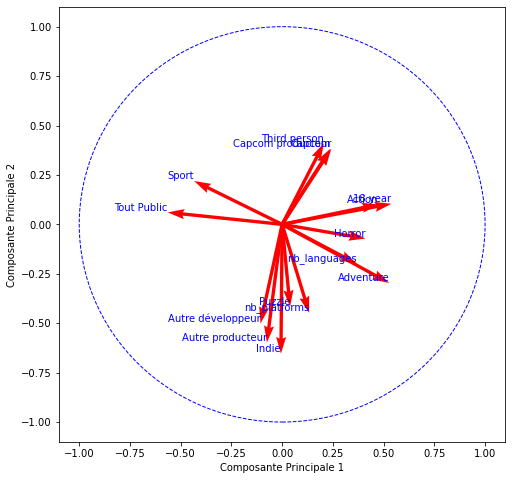

In [74]:
fig, ax = plt.subplots(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, edgecolor='b', facecolor='None', linestyle='--')
ax.add_patch(circle)

for i in range(len(tab['abs'])) : 
    ax.quiver(0, 0, tab['abs'][i], tab['ordo'][i], angles='xy', scale_units='xy', scale=1, color='r')

for i, txt in enumerate(tab['id']):
    ax.annotate(txt, (tab['abs'][i], tab['ordo'][i]), color='b', ha='right', va='bottom')

ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)

ax.set_xlabel('Composante Principale 1')
ax.set_ylabel('Composante Principale 2')

plt.show()

On trace ici le graphique représentant l'inertie dans le contexte de la méthode du coude (Elbow Method). Elle est souvent utilisée pour évaluer la qualité de l'ajustement du modèle en fonction du nombre de composantes principales retenues. 

Il s'agit de la quantité totale de variance dans les données en fonction du nombre de composante principales retenues : au niveau du point d'inflexion on considère que l'ajout de composantes principales par la suite n'apporte qu'une amélioration marginale de l'explication de la variance. 

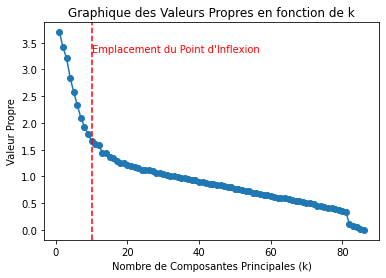

In [75]:
#Les valeurs propres en fonction du nombre de composantes et on entoure le point d'inflexion
k_values = np.arange(1, len(val_p) + 1)
#der_seconde = np.diff(np.diff(val_p))
point_inflexion = 10

plt.plot(k_values, val_p, marker='o', linestyle='-')
plt.axvline(x = point_inflexion, color='red', linestyle='--', label='Point d\'Inflexion')
plt.text(point_inflexion + 0.1, max(val_p) * 0.9, 'Emplacement du Point d\'Inflexion', color='red')

plt.xlabel('Nombre de Composantes Principales (k)')
plt.ylabel('Valeur Propre')
plt.title('Graphique des Valeurs Propres en fonction de k')
plt.show()

On retient donc 10 composantes principales après notre analyse, c'est un nombre conséquent mais ce n'est pas surprenant compte tenu de la faible corrélation des variables explicatives entre elles dans notre base...

Ici, nous allons rentrer les 10 premières composantes principales dans un dateframe qui sont donc 10 variables composites (combinaisons linéaires de nos variables initiales) qui résument le mieux l'information contenue dans notre DataFrame. 

In [76]:
tab_ACP = pca.transform(DF_ACP_scaled)

DF_ACP = pd.DataFrame(tab_ACP[:, :10], columns = [f'{i+1}ème Composante Principale' for i in range(10)])

On peut vérifier que nos composantes principales sont bien le produit matriciel de notre dataframe par les vecteurs propres obtenus via l'ACP : 

In [77]:
for i in range(10) : 
    print(DF_ACP_scaled @ pca.components_[i])

DF_ACP

0       2.270677
1       1.899338
2      -1.738472
3       0.736193
4       0.382948
          ...   
2732   -0.681755
2733    1.325734
2734   -1.375915
2735   -0.749266
2736   -1.715032
Length: 2737, dtype: float64
0       1.731763
1       4.130316
2      -1.305103
3      -1.966911
4      -1.385784
          ...   
2732   -0.118558
2733   -1.044249
2734   -0.551322
2735    2.574052
2736   -0.345172
Length: 2737, dtype: float64
0       0.605193
1      -3.038123
2       2.349541
3      -1.432928
4       1.573127
          ...   
2732   -1.471097
2733    0.912041
2734    0.114206
2735    0.269704
2736   -0.215440
Length: 2737, dtype: float64
0      -1.274759
1      -4.557111
2       1.727337
3      -0.226945
4      -0.973999
          ...   
2732    0.744988
2733   -0.201849
2734    0.416112
2735   -2.214412
2736   -0.309345
Length: 2737, dtype: float64
0      -1.141596
1       2.288905
2      -0.368519
3      -0.675789
4      -0.865540
          ...   
2732   -1.529714
2733   -0.233298


,1ème Composante Principale,2ème Composante Principale,3ème Composante Principale,4ème Composante Principale,5ème Composante Principale,6ème Composante Principale,7ème Composante Principale,8ème Composante Principale,9ème Composante Principale,10ème Composante Principale
0,2.270677,1.731763,0.605193,-1.274759,-1.141596,-2.924680,-0.905048,-0.170904,-2.052236,0.057029
1,1.899338,4.130316,-3.038123,-4.557111,2.288905,8.953959,-0.578991,3.544194,-1.536098,0.833466
2,-1.738472,-1.305103,2.349541,1.727337,-0.368519,1.437821,0.287572,-0.482551,0.104468,-0.422532
3,0.736193,-1.966911,-1.432928,-0.226945,-0.675789,0.525996,-0.391580,0.436243,1.337556,-0.659782
4,0.382948,-1.385784,1.573127,-0.973999,-0.865540,0.342506,-0.446999,-1.155224,-0.852162,0.547019
...,...,...,...,...,...,...,...,...,...,...
2732,-0.681755,-0.118558,-1.471097,0.744988,-1.529714,0.757922,2.224354,-0.712413,0.762806,1.589991
2733,1.325734,-1.044249,0.912041,-0.201849,-0.233298,-0.664965,-0.210701,-1.617292,-0.390171,0.404340
2734,-1.375915,-0.551322,0.114206,0.416112,0.023001,-0.178320,-2.237069,-1.080658,-0.969906,-0.092216
2735,-0.749266,2.574052,0.269704,-2.214412,-0.356347,-1.656039,-1.312000,0.035433,1.456590,0.070508


Par la suite, nos allons donc pouvoir tenter des techniques statistiques de prédictions sur ce DataFrame à l'information résumée afin de comparer notre capacité prédictive avec ce que nous avons pu trouver auparavant sur le dataframe complet. 

On a donc le cercle des corrélations avec les plus grands vecteurs en dimension deux, on peut distinguer des clusters mais pas ultra clair...
Voir comment interpréter ça, et voir le grpahique du coude pour voir combien de dimensions on pourrait avoir, ensuite créer un dataframe avec le nombre de dimension idéal, le % de variance expliquée avec et faire de régressions sur ça. ON comparera par la suite avec la big reg sur toutes les données pour voir si c'est carré comme réduction de dim ou pas